# House prices: Lasso, XGBoost, and a detailed EDA

## 1 Executive Summary

I started this competition by just focusing on getting a good understanding of the dataset. The EDA is detailed and many visualizations are included. This version also includes modeling.

 *EDA: 탐색적 자료 분석

* Lasso regressions (오차에 제곱 대신 절대값을 씌워 계산하는 회귀분석법) 은 0.1121 수치의 RMSE(평균 제곱근 오차) 교차 검증을 하기 좋다. 주어진 사실에 의하면 변수 사이에 multicollinearity(다중 공선성)이 예측된다. Lasso는 상당수의 변수를 선택하지 않을 것이다.

* XGBoost 모델도 0.1162 수치의 RMSE 교차 검증을 하기 좋다.

* 두 알고리즘은 매우 다르지만 평균 예측에 있어 예측도를 더 높여줄 것이다. LassoE가 XGBoost의 교차 검증 score보다 결과가 좋았기에, Lasso 결과의 두 배를 가중치로 두기로 했다.

*다중공선성: P개의 독립변수와 1개의 종속변수가 있을 때, P개의 독립변수들 사이에 높은 상관관계가 있는 상태

*XGBOOST: eXtreme Gradient Boosting

## 2 Introduction
Kaggle describes this competition as follows:

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variales describing (almost) every aspect of residntial homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## 3 Loading and Exploring Data

### 3.1 Loading libraries required and reading the data into R

Loading R packages used besides base R.

In [57]:
install.packages("corrplot", repos="http://cran.us.r-project.org")
install.packages('Rmisc', dependencies = TRUE, repos="http://cran.us.r-project.org")
install.packages("psych", repos="http://cran.us.r-project.org")
install.packages("ggrepel", repos="http://cran.us.r-project.org")
install.packages("xgboost", repos="http://cran.us.r-project.org")

Warning message:
"package 'corrplot' is in use and will not be installed"Warning message:
"package 'Rmisc' is in use and will not be installed"Warning message:
"package 'psych' is in use and will not be installed"Warning message:
"package 'ggrepel' is in use and will not be installed"

package 'xgboost' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\semai\AppData\Local\Temp\Rtmpu25MPK\downloaded_packages


In [2]:
library(knitr)
library(ggplot2)
library(plyr)
library(corrplot)
library(dplyr)
library(caret)
library(gridExtra)
library(scales)
library(scales)
library(Rmisc)
library(ggrepel)
library(randomForest)
library(psych)
library(xgboost)

Warning message:
"package 'corrplot' was built under R version 3.5.2"corrplot 0.84 loaded

Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice
Warning message:
"package 'gridExtra' was built under R version 3.5.2"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'Rmisc' was built under R version 3.5.2"Warning message:
"package 'ggrepel' was built under R version 3.5.2"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:gridExtra':

    combine

The following object is masked from 'package:dplyr':

   

In [3]:
train <- read.csv("train.csv", stringsAsFactors = F)
test <- read.csv("test.csv", stringsAsFactors = F)

### 3.2 Data size and structure
The train dataset consist of character and integer variables. Most of the character variables are acutally ordinal factors, but I chose to read them into R as character strings as most of them require cleaning and/or feature engineering first. In total, there are 81 columns/variables, of which the last one is the response variable (SalePrice). Below, I am displaying only a glimpse of the variables. All of them are discussed in more detail throughout the document.

In [4]:
dim(train)

[1] 1460   81

In [5]:
str(train[,c(1:10, 81)]) #첫 10개 변수와 대응 변수

'data.frame':	1460 obs. of  11 variables:
 $ Id         : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning   : chr  "RL" "RL" "RL" "RL" ...
 $ LotFrontage: int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea    : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street     : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley      : chr  NA NA NA NA ...
 $ LotShape   : chr  "Reg" "Reg" "IR1" "IR1" ...
 $ LandContour: chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ Utilities  : chr  "AllPub" "AllPub" "AllPub" "AllPub" ...
 $ SalePrice  : int  208500 181500 223500 140000 250000 143000 307000 200000 129900 118000 ...


In [6]:
#ID는 제거하지만 테스트 ID는 남겨놓음. 파일 제출하는 데 필요함.
test_labels <- test$Id
test$Id <- NULL
train$Id <- NULL

test$SalePrice <- NA
all <- rbind(train, test)
dim(all)

[1] 2919   80

Id 없이 데이터 프레임은 79개의 예측변수와 SalePrice 응답 변수로 이뤄짐.

## 4 Exploring some of the most important variables

### 4.1 The response variable; SalePrice

sale price는 right skewed이다. 이것은 소수의 사람들이 비싼 집을 살 여유가 있다는 사실을 의미한다. 이 사실을 염두에 두고 모델링 하기 전에 조취를 취할 것이다.

*right skewed: 평균이 median 보다 큼

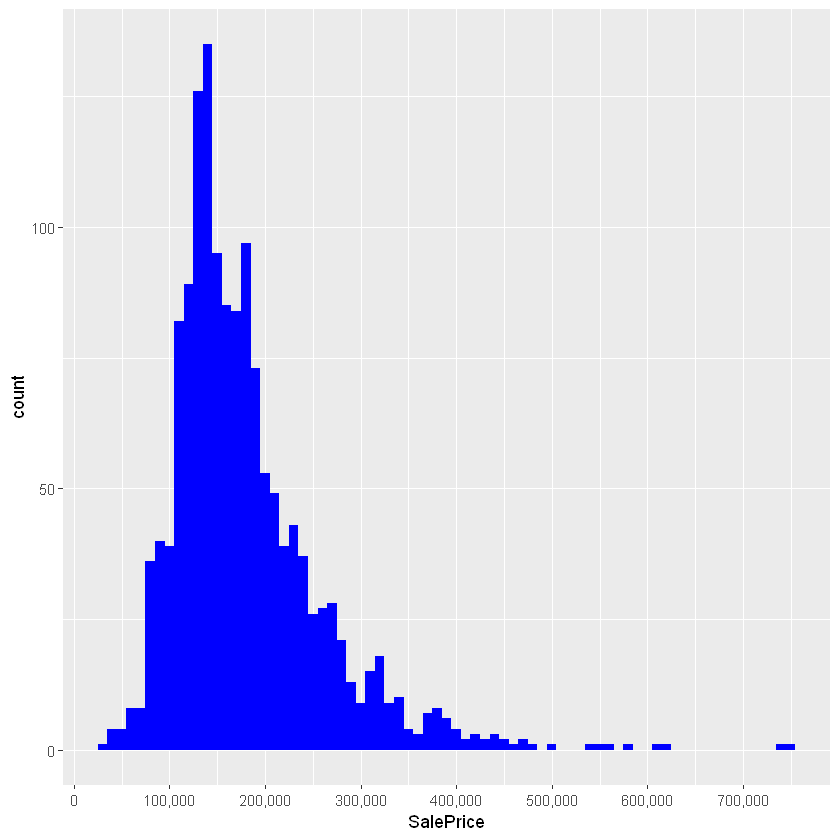

In [7]:
ggplot(data=all[!is.na(all$SalePrice),], aes(x=SalePrice)) +
        geom_histogram(fill="blue", binwidth = 10000) +
        scale_x_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

In [8]:
summary(all$SalePrice)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  34900  129975  163000  180921  214000  755000    1459 

### 4.2 The most important numeric predictors
캐릭터 변수를 사용하기 전에 해야할 것이 있다. dataset을 보기 전에 어떤 numeric 변수가 SalePrice와 높은 상관관계가 있는지 보기로 했다.

#### 4.2.1 Correlations with SalePrice
SalePrice와 적어도 0.5 이상의 상관관계가 있는 numeric 변수가 10개 있다. 이 모든 상관관계는 positive하다.

In [9]:
numericVars <- which(sapply(all, is.numeric)) #index vector numeric variables
numericVarNames <- names(numericVars) # saving names vector for use later on
cat('There are', length(numericVars), 'numeric variables')

There are 37 numeric variables

In [10]:
all_numVar <- all[, numericVars]
cor_numVar <- cor(all_numVar, use="pairwise.complete.obs") #correlations of all numeric variables

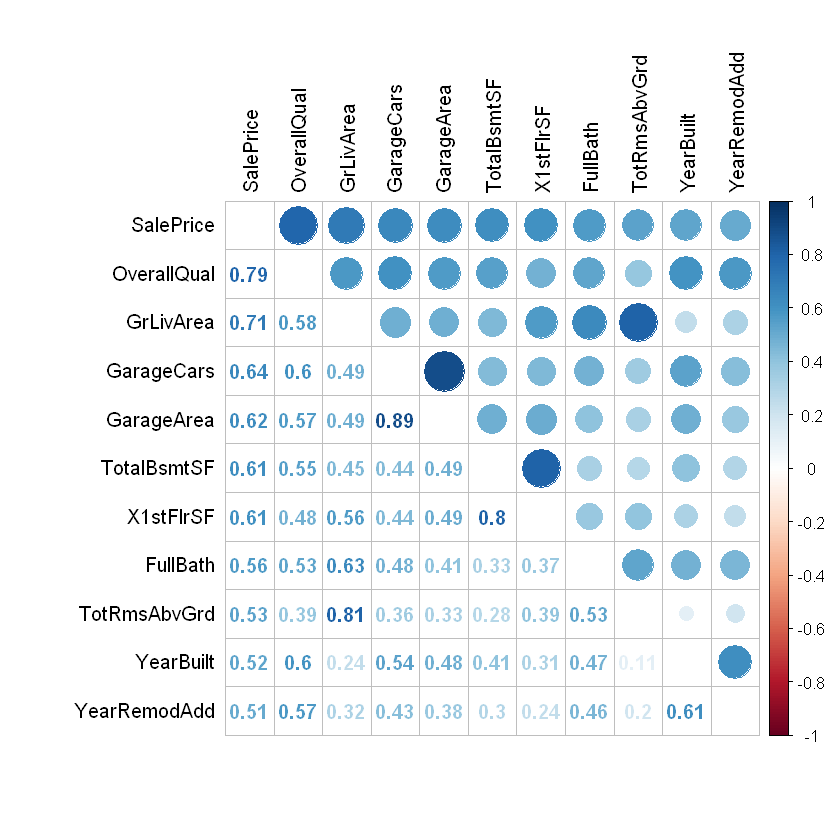

In [11]:
# sort on decreasing correlations with SalePrice
cor_sorted <- as.matrix(sort(cor_numVar[,'SalePrice'], decreasing = TRUE))
# select only high correlations
CorHigh <- names(which(apply(cor_sorted, 1, function(x) abs(x)>0.5)))
cor_numVar <- cor_numVar[CorHigh, CorHigh]
                             
corrplot.mixed(cor_numVar, tl.col="black", tl.pos = "lt")

이 섹션에서 기억해둘 점은 SalePrice와 높은 상관 관계에 있는 두 가지 예측 변수(Overall Quality&Above Grade Living Area-*not 반지하*)와의 관계를 시각화한 것이다.

다중공선성 이슈를 명확하게 하기도 한다. 예를 들어, GarageCars와 GarageArea는 매우 높은 (0.89) 상관 관계에 있고 SalePrice와의 상관 관계가 비슷하다. 
SalePrice와의 상관 관계가 0.5보다 높은 그 외의 6개 변수들: 
- TotalBsmtSF: Total square feet of basement area
- 1stFlrSF: First Floor square feet
- FullBath: Full bathrooms above grade
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

### 4.2.2 Overall Quality
Overall Quality는 numeric 변수 중에서 SalePrice와 가장 높은 상관 관계를 가진다(0.79). 집의 전체 재료와 마무리를 1(안 좋음)에서부터 10(좋음) 사이로 평가한다.

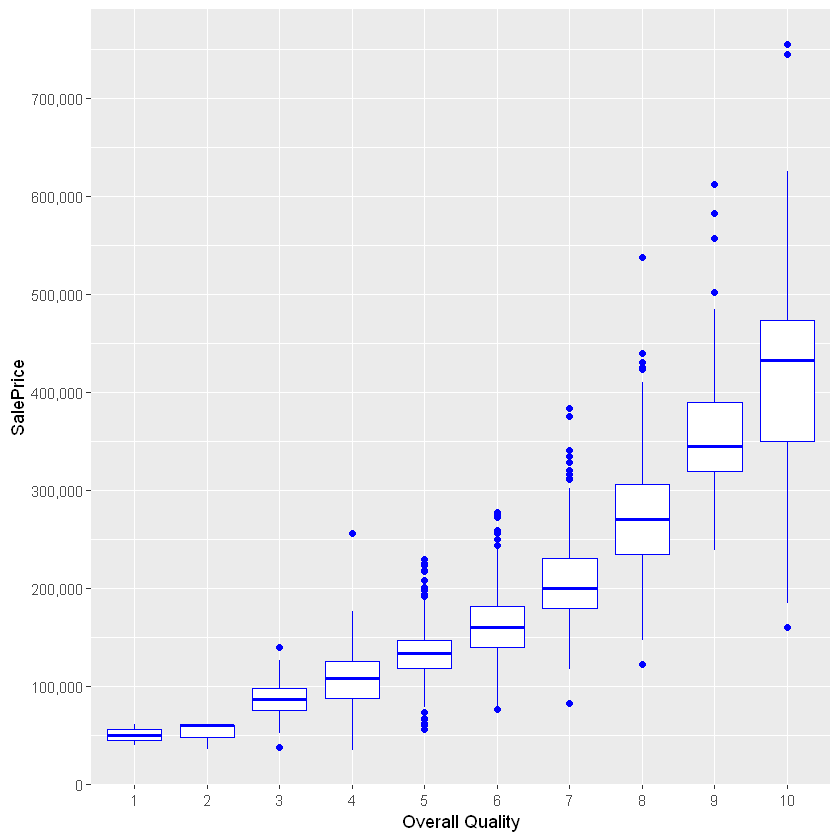

In [12]:
ggplot(data=all[!is.na(all$SalePrice),], aes(x=factor(OverallQual),
                                            y=SalePrice))+
geom_boxplot(col='blue') + labs(x='Overall Quality') +
scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

약간 위로 올라가는 곡선 모양으로 positive한 상관 관계가 나타난다. 극단적인 특이치는 없다. 후에 특이치 후보로는 등급이 4인 비싼 집이 올라갈 것으로 보인다.

### 4.2.3 Aobve Grade (Ground) Living Area (square feet)
numeric 변수 중에서 SalesPrice와 두 번째로 높은 상관 관계를 보인 건 Above Grade Living Area이다. 큰 집은 보통 비싸다는 것을 보여준다.

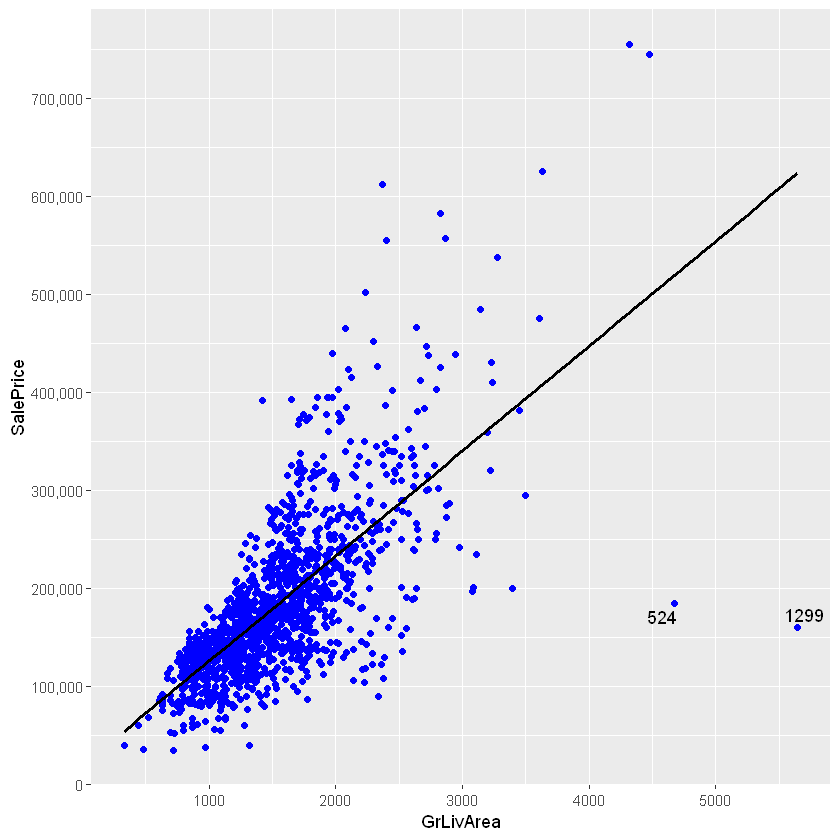

In [13]:
ggplot(data=all[!is.na(all$SalePrice),], aes(x=GrLivArea, y=SalePrice))+
        geom_point(col='blue') + geom_smooth(method = "lm", se=FALSE, color="black", aes(group=1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma) +
        geom_text_repel(aes(label = ifelse(all$GrLivArea[!is.na(all$SalePrice)]>4500, rownames(all), '')))

특히 living area가 크지만 SalePrices가 낮은 두 집은 특이치로 나타난다. (그래프에서 524와 1299인 부분). 특이치를 제외하는 건 위험할 수 있기 때문에 아직은 제거하지 않을 생각이다. 예를 들면 Overall Qaulity가 낮다는 건 낮은 가격을 의미하는데 아래를 보면 알 수 있듯이 이 두 집은 Overall Quality의 점수가 최대치이다. 따라서, 1299와 524 집은 제외할 특이치의 주요 후보로 놔둘 생각이다.

In [14]:
all[c(524, 1299), c('SalePrice', 'GrLivArea', 'OverallQual')]

,SalePrice,GrLivArea,OverallQual
524,184750,4676,10
1299,160000,5642,10


## 5 Missing data, label encoding, and factorizing variables

### 5.1 Completeness of the data

일단 어떤 변수가 missing values인지 보도록 하자.

In [15]:
NAcol <- which(colSums(is.na(all)) > 0)
sort(colSums(sapply(all[NAcol], is.na)), decreasing = TRUE)

PoolQC  MiscFeature        Alley        Fence    SalePrice  FireplaceQu 
        2909         2814         2721         2348         1459         1420 
 LotFrontage  GarageYrBlt GarageFinish   GarageQual   GarageCond   GarageType 
         486          159          159          159          159          157 
    BsmtCond BsmtExposure     BsmtQual BsmtFinType2 BsmtFinType1   MasVnrType 
          82           82           81           80           79           24 
  MasVnrArea     MSZoning    Utilities BsmtFullBath BsmtHalfBath   Functional 
          23            4            2            2            2            2 
 Exterior1st  Exterior2nd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF 
           1            1            1            1            1            1 
  Electrical  KitchenQual   GarageCars   GarageArea     SaleType 
           1            1            1            1            1

In [16]:
cat('There are', length(NAcol), 'columns with missing values')

There are 35 columns with missing values

SalePrice에서 1459개의 NA가 나온 것은 test set 사이즈와 똑같기 때문에 34개의 예측 변수에서 NA를 고쳐야 한다는 말이 된다.

### 5.2 Imputing missing data
이 섹션에서 missing value를 포함하고 있는 34개의 예측 변수를 고치려고 한다. 가장 NA가 많은 것부터 전부 고쳐질 때까지 조사하려고 한다. 만약 다른 변수와 그룹을 형성하고 있는 변수를 만나면 그룹으로 다룰 것이다. 예를 들면 Pool, Garage, Basement와 관련된 많은 변수들이 있다.

편의성을 위해 knitr가 제공하는 "Tabs" 옵션을 사용했다. 각 탭에서 각 그룹 변수들의 간단한 분석을 볼 수 있다. 모든 탭을 볼 필요는 없지만 몇 개는 보길 바란다. 어떤 집이 basement와 garage가 없는지 결정했기 때문에 Garage와 Basement에 가치가 있다는 것을 알게 될 것이다.

NA처리 외에도 character 변수를 순서가 있는 경우에는 ordinal integers로, 순서가 없고 범주화 되어 있는 경우에는 factors로 변환했다. 나중에 one-hot encoding을 이용하여 factors를 numeric으로 바꿀 것이다.

-----------------------------------------------
5.2.1-6,9-16 코드

**Pool variables**

In [17]:
all$PoolQC[is.na(all$PoolQC)] <- 'None'

In [18]:
Qualities <- c('None' = 0, 'Po' = 1, 'Fa' = 2, 'TA' = 3, 'Gd' = 4, 'Ex' = 5)

In [19]:
all$PoolQC<-as.integer(revalue(all$PoolQC, Qualities))
table(all$PoolQC)

The following `from` values were not present in `x`: Po, TA



   0    2    4    5 
2909    2    4    4 

In [20]:
all[all$PoolArea>0 & all$PoolQC==0, c('PoolArea', 'PoolQC', 'OverallQual')]

,PoolArea,PoolQC,OverallQual
2421,368,0,4
2504,444,0,6
2600,561,0,3


In [21]:
all$PoolQC[2421] <- 2
all$PoolQC[2504] <- 3
all$PoolQC[2600] <- 2

**Miscellaneous Feature**

   Elev Elevator
   Gar2 2nd Garage (if not described in garage section)
   Othr Other
   Shed Shed (over 100 SF)
   TenC Tennis Court
   NA   None

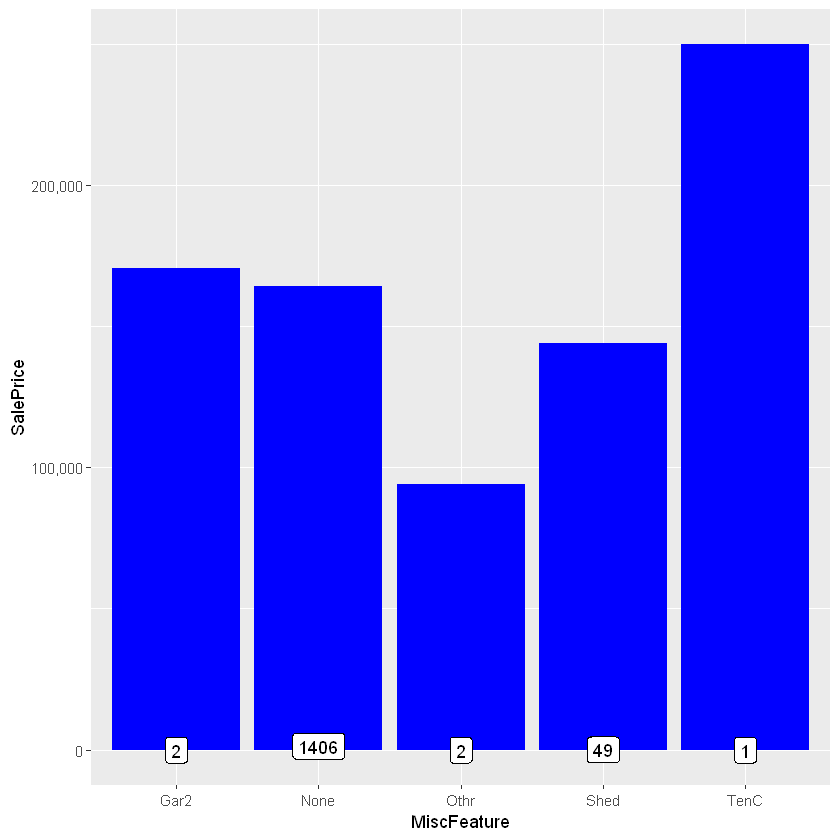

In [22]:
all$MiscFeature[is.na(all$MiscFeature)] <- 'None'
all$MiscFeature <- as.factor(all$MiscFeature)

ggplot(all[!is.na(all$SalePrice),], aes(x=MiscFeature, y=SalePrice)) +
geom_bar(stat='summary', fun.y = "median", fill='blue') +
scale_y_continuous(breaks=seq(0, 800000, by=100000), labels=comma)+
geom_label(stat="count", aes(label= ..count.., y=..count..))

In [23]:
table(all$MiscFeature)


Gar2 None Othr Shed TenC 
   5 2814    4   95    1 

**Alley**

   Grvl Gravel
   Pave Paved
   NA   No alley access

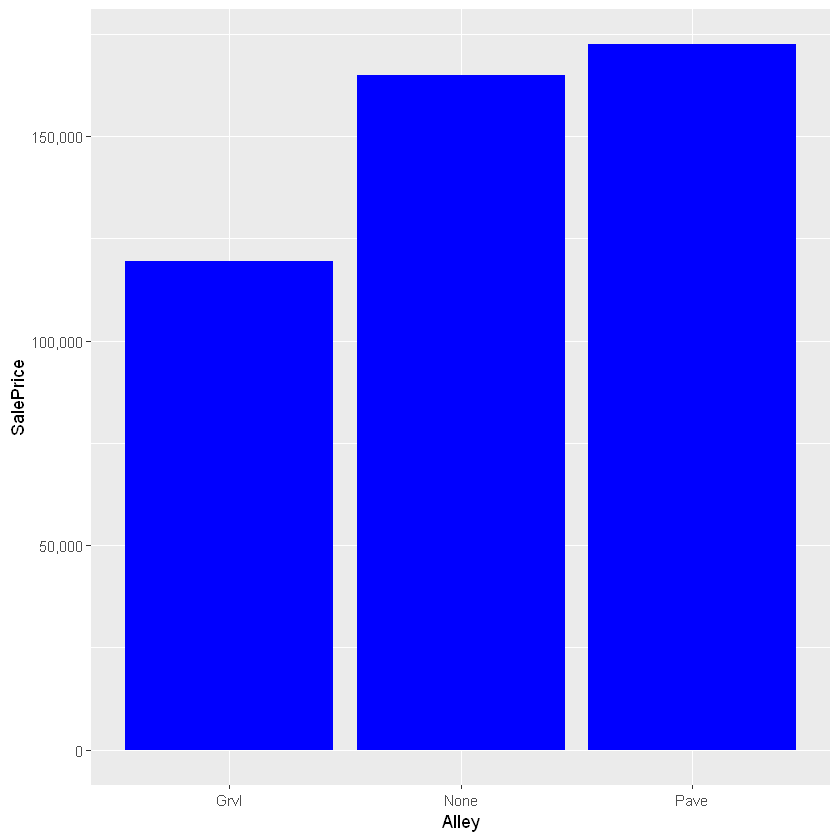

In [24]:
all$Alley[is.na(all$Alley)]<-'None'
all$Alley <- as.factor(all$Alley)

ggplot(all[!is.na(all$SalePrice),], aes(x=Alley, y=SalePrice)) +
geom_bar(stat='summary', fun.y="median", fill='blue')+
scale_y_continuous(breaks= seq(0, 200000, by = 50000), labels = comma)

In [25]:
table(all$Alley)


Grvl None Pave 
 120 2721   78 

**Fence quality**

   GdPrv    Good Privacy
   MnPrv    Minimum Privacy
   GdWo Good Wood
   MnWw Minimum Wood/Wire
   NA   No Fence

In [26]:
all$Fence[is.na(all$Fence)] <- 'None'
table(all$Fence)


GdPrv  GdWo MnPrv  MnWw  None 
  118   112   329    12  2348 

In [27]:
all[!is.na(all$SalePrice),] %>% group_by(Fence) %>% summarise(median =
                                                            median(SalePrice), counts=n())

Fence,median,counts
GdPrv,167500,59
GdWo,138750,54
MnPrv,137450,157
MnWw,130000,11
None,173000,1179


In [28]:
all$Fence <- as.factor(all$Fence)

**Fireplace quality**

   Ex   Excellent - Exceptional Masonry Fireplace
   Gd   Good - Masonry Fireplace in main level
   TA   Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
   Fa   Fair - Prefabricated Fireplace in basement
   Po   Poor - Ben Franklin Stove
   NA   No Fireplace

In [29]:
all$FireplaceQu[is.na(all$FireplaceQu)] <- 'None'
all$FireplaceQu<-as.integer(revalue(all$FireplaceQu, Qualities))
table(all$FireplaceQu)


   0    1    2    3    4    5 
1420   46   74  592  744   43 

In [30]:
table(all$Fireplaces)


   0    1    2    3    4 
1420 1268  219   11    1 

In [31]:
sum(table(all$Fireplaces))

[1] 2919

**Lot variables**<br>
-LotFrontage: Linear feet of street connected  to property

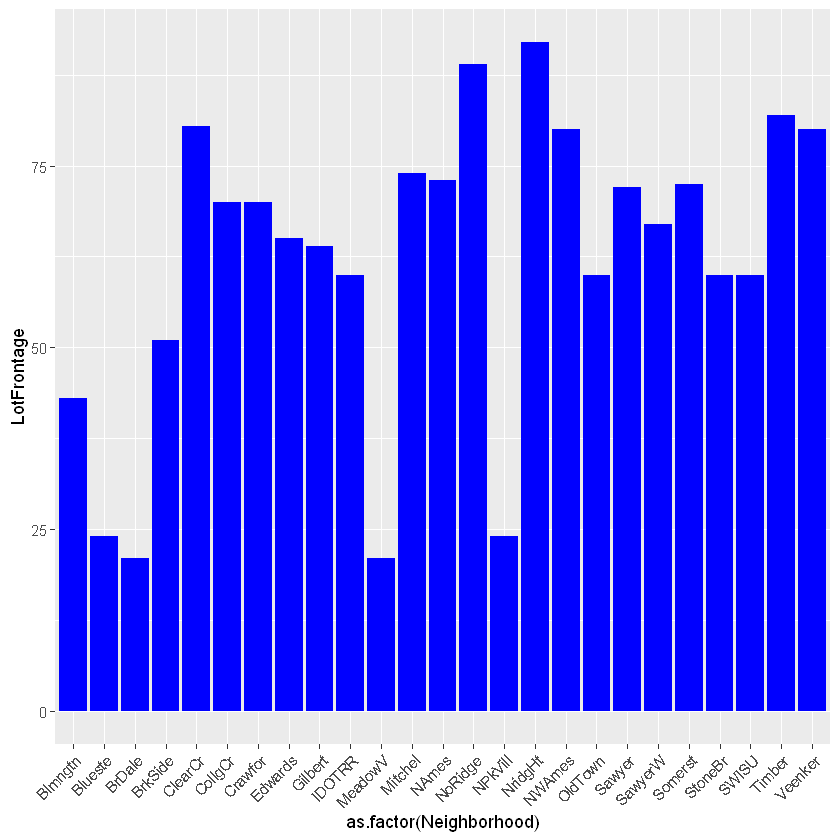

In [32]:
ggplot(all[!is.na(all$LotFrontage),], aes(x=as.factor(Neighborhood), y=LotFrontage)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [33]:
for (i in 1:nrow(all)){
        if(is.na(all$LotFrontage[i])){
               all$LotFrontage[i] <- as.integer(median(all$LotFrontage[all$Neighborhood==all$Neighborhood[i]], na.rm=TRUE)) 
        }
}

   Reg  Regular 
   IR1  Slightly irregular
   IR2  Moderately Irregular
   IR3  Irregular

In [34]:
all$LotShape<-as.integer(revalue(all$LotShape, c('IR3'=0, 'IR2'=1, 'IR1'=2, 'Reg'=3)))
table(all$LotShape)


   0    1    2    3 
  16   76  968 1859 

In [96]:
sum(table(all$LotShape))

[1] 2919

   Inside   Inside lot
   Corner   Corner lot
   CulDSac  Cul-de-sac
   FR2  Frontage on 2 sides of property
   FR3  Frontage on 3 sides of property

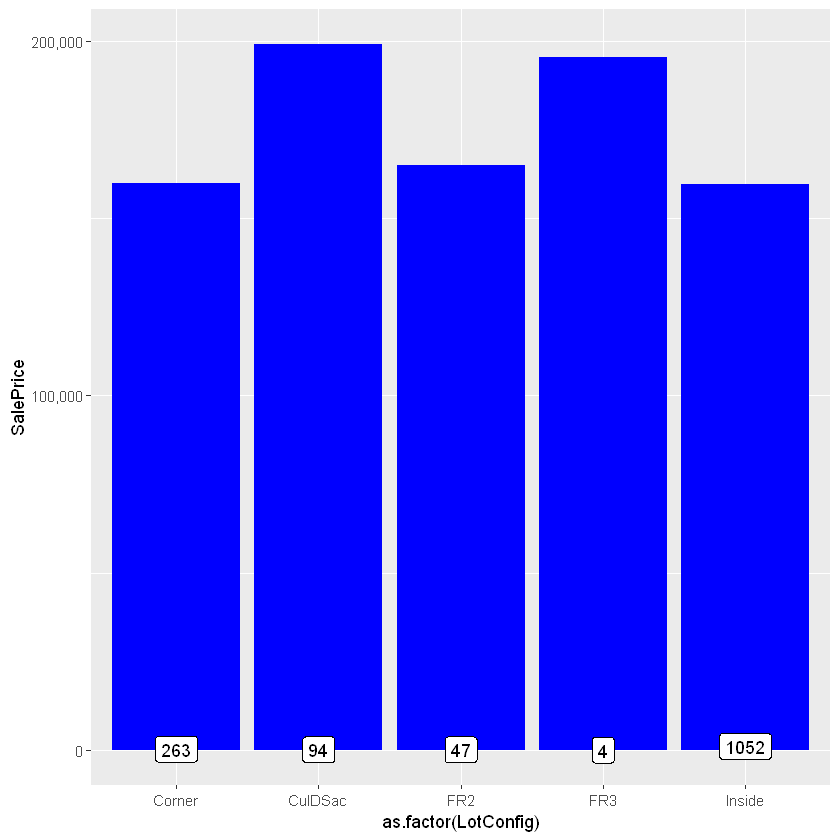

In [35]:
ggplot(all[!is.na(all$SalePrice),], aes(x=as.factor(LotConfig), y=SalePrice)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue')+
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma) +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..))

In [36]:
all$LotConfig <- as.factor(all$LotConfig)
table(all$LotConfig)


 Corner CulDSac     FR2     FR3  Inside 
    511     176      85      14    2133 

In [37]:
sum(table(all$LotConfig))

[1] 2919

-----------------------------------------------------------------------------

#### 5.2.7 Garage Variables

##### 종합 7개의 변수가 garage와 관련이 있다.

GarageCars와 GarageArea가 하나의 NA를 갖고, GarageType이 157개의 NA, 4개 변수가 159개의 NA를 갖고 있다.

159개의 missing **GarageYrBLT: Year garage was buit**값을 전부 YearBuilt에 있는 값으로 대체했다.

   *YearBuilt는 리모델링하지 않았으면 default 값으로 들어가는 YearRemodAdd와 비슷하다.

In [38]:
all$GarageYrBlt[is.na(all$GarageYrBlt)] <- all$YearBuilt[is.na(all$GarageYrBlt)]

NA가 character 변수의 'No Garage'를 의미하기 때문에 157개의 NA GarageType과 159개의 NA를 가진 다른 3개의 character 변수 사이의 차이가 어디서 오는 건지 확인하려고 한다.

In [39]:
# check if all 157 NAs are the same observations among the variables with 157/159 NAs
length(which(is.na(all$GarageType) & is.na(all$GarageFinish) & is.na(all$GarageCond) & is.na(all$GarageQual)))

[1] 157

In [40]:
#Find the 2 additional NAs
kable(all[!is.na(all$GarageType) & is.na(all$GarageFinish), c('GarageCars', 'GarageArea', 'GarageType', 'GarageCond', 'GarageQual', 'GarageFinish')])



|     | GarageCars| GarageArea|GarageType |GarageCond |GarageQual |GarageFinish |
|:----|----------:|----------:|:----------|:----------|:----------|:------------|
|2127 |          1|        360|Detchd     |NA         |NA         |NA           |
|2577 |         NA|         NA|Detchd     |NA         |NA         |NA           |

GarageType의 157개 NA는 모두 GarageCondition, GarageQuality, GarageFinish의 NA라는 것을 알았다. 집 2127과 2577에서 차이가 보인다. 집 2127은 Garage를 가진 것 같지만 2577은 그렇지 않다. 따라서 Garage가 없는 집은 158채가 되어야 한다. 집 2127을 고치기 위해 GarageCondition, GarageQuality, GarageFinish에서 가장 흔한 값을 imputate하겠다.

In [41]:
#Imputing modes.
all$GarageCond[2127] <- names(sort(-table(all$GarageCond)))[1]
all$GarageQual[2127] <- names(sort(-table(all$GarageQual)))[1]
all$GarageFinish[2127] <- names(sort(-table(all$GarageFinish)))[1]

#display "fixed" house
kable(all[2127, c('GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageType', 'GarageCond', 'GarageQual', 'GarageFinish')])



|     | GarageYrBlt| GarageCars| GarageArea|GarageType |GarageCond |GarageQual |GarageFinish |
|:----|-----------:|----------:|----------:|:----------|:----------|:----------|:------------|
|2127 |        1910|          1|        360|Detchd     |TA         |TA         |Unf          |

GarageCars and GarageArea: Size of garage in car capacity and Size of garage in square

둘 다 한 개의 NA를 갖고 있다. 위에서 봤듯이 집 2577이 그렇다. 다른 Garage 변수들이 이 집은 Garage가 없음을 나타내고 있기 때문에, 문제는 이 집의 GarageType이 "detached"되어서 나타날 가능성이 높다.

In [42]:
#fixing 3 value for house 2577
all$GarageCars[2577] <- 0
all$GarageArea[2577] <- 0
all$GarageType[2577] <- NA

#check if NAs of the character variables are now all 158
length(which(is.na(all$GarageType) & is.na(all$GarageFinish) & is.na(all$GarageCond) & is.na(all$GarageQual)))

[1] 158

이제 garage와 관련된 4개의 캐릭터 변수들이 모두 158개의 NA를 가졌다. 이 섹션의 나머지 부분에서 남은 부분을 모두 고치겠다.

*NA means No Garage

**Garage Type: Garage location**

값이 ordinal하지 않기에 factor로 바꾼다.

   2Types     More than one type of garage
   Attchd     Attached to home
   Basement   Basement Garage
   BuiltIn    Built-In (Garage part of house - typically has room above garage)
   CarPort    Car Port
   Detchd     Detached from home
   NA         No Garage

In [43]:
all$GarageType[is.na(all$GarageType)] <- 'No Garage'
all$GarageType <- as.factor(all$GarageType)
table(all$GarageType)


   2Types    Attchd   Basment   BuiltIn   CarPort    Detchd No Garage 
       23      1723        36       186        15       778       158 

**GarageFinish: Interior finish of the garage**

값은 ordinal하다.

   Fin      Finished
   RFn      Rough Finished
   Unf      Unfinished
   NA       No Garage

In [44]:
all$GarageFinish[is.na(all$GarageFinish)] <- 'None'
Finish <- c('None'=0, 'Unf'=1, 'RFn'=2, 'Fin'=3)

In [45]:
all$GarageFinish<-as.integer(revalue(all$GarageFinish, Finish))
table(all$GarageFinish)


   0    1    2    3 
 158 1231  811  719 

**GarageQual: Garage quality**

다른 변수는 Qualities vector로 ordinal을 만들 수 있다.

   Ex     Excellent
   Gd     Good
   TA     Typical/Average
   Fa     Fair
   Po     Poor
   NA     No Garage

In [46]:
Qualities <- c('None'=0, 'Po'=1, 'Fa'=2, 'TA'=3, 'Gd'=4, 'Ex'=5)
all$GarageQual[is.na(all$GarageQual)] <- 'None'
all$GarageQual<-as.integer(revalue(all$GarageQual, Qualities))
table(all$GarageQual)


   0    1    2    3    4    5 
 158    5  124 2605   24    3 

**GarageCond: Garage condition**

상기 동일

   Ex     Excellent
   Gd     Good
   TA     Typical/Average
   Fa     Fair
   Po     Poor
   NA     No Garage

In [47]:
all$GarageCond[is.na(all$GarageCond)] <- 'None'
all$GarageCond<-as.integer(revalue(all$GarageCond, Qualities))
table(all$GarageCond)


   0    1    2    3    4    5 
 158   14   74 2655   15    3 

#### 5.2.8 Basement Variables

5개의 변수가 79-82개의 NA를, 6개의 변수가 하나 또는 두 개의 NA를 갖고 있다.

In [48]:
#check if all 79 NAs are the same observations among the variables with 80+ NAs
length(which(is.na(all$BsmtQual) & is.na(all$BsmtCond) & is.na(all$BsmtExposure) & is.na(all$BsmtFinType1) & is.na(all$BsmtFinType2)))

[1] 79

In [49]:
#Find the additional NAs; BsmtFinType1 is the one with 79 NAs
all[!is.na(all$BsmtFinType1) & (is.na(all$BsmtCond)|is.na(all$BsmtQual)|is.na(all$BsmtExposure)|is.na(all$BsmtFinType2)), c('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2')]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
333,Gd,TA,No,GLQ,NA
949,Gd,TA,NA,Unf,Unf
1488,Gd,TA,NA,Unf,Unf
2041,Gd,NA,Mn,GLQ,Rec
2186,TA,NA,No,BLQ,Unf
2218,NA,Fa,No,Unf,Unf
2219,NA,TA,No,Unf,Unf
2349,Gd,TA,NA,Unf,Unf
2525,TA,NA,Av,ALQ,Unf


종합해봤을 때 missing values가 있는 다른 집의 basement 변수가 80%이기 때문에 (missing 1 out of 5 values) 지하실이 없는 집이 79채가 된다. 이 9채를 고치기 위한 modes를 impute한다.

In [50]:
#Imputing modes.
all$BsmtFinType2[333] <- names(sort(-table(all$BsmtFinType2)))[1]
all$BsmtExposure[c(949, 1488, 2349)] <- names(sort(-table(all$BsmtExposure)))[1]
all$BsmtCond[c(2041, 2186, 2525)] <- names(sort(-table(all$BsmtCond)))[1]
all$BsmtQual[c(2218, 2219)] <- names(sort(-table(all$BsmtQual)))[1]

5개의 변수로 79채의 집이 basement가 없다는 것을 알 수 있었다. 이후부터 factorize/hot encode를 하겠다.

**BsmtQual: Evaluates the height of the basement**

ordinal에서 Qualities vector로 변수가 만들어진다.

   Ex   Excellent (100+ inches)
   Gd   Good (90-99 inches)
   TA   Typical (80-89 inches)
   Fa   Fair (70-79 inches)
   Po   Poor (<70 inches)
   NA   No Basement

In [51]:
all$BsmtQual[is.na(all$BsmtQual)] <- 'None'
all$BsmtQual<-as.integer(revalue(all$BsmtQual, Qualities))
table(all$BsmtQual)

The following `from` values were not present in `x`: Po



   0    2    3    4    5 
  79   88 1285 1209  258 

**BmstCond: Evaluates the general condition of the basement**

ordinal을 Qualities vector로 만든 변수

   Ex   Excellent
   Gd   Good
   TA   Typical - slight dampness allowed
   Fa   Fair - dampness or some cracking or settling
   Po   Poor - Severe cracking, settling, or wetness
   NA   No Basement

In [52]:
all$BsmtCond[is.na(all$BsmtCond)] <- 'None'
all$BsmtCond<-as.integer(revalue(all$BsmtCond, Qualities))
table(all$BsmtCond)

The following `from` values were not present in `x`: Ex



   0    1    2    3    4 
  79    5  104 2609  122 

**BsmtExposure: Refers to walkout or garden level walls**

ordinal 변수

   Gd   Good Exposure
   Av   Average Exposure (split levels or foyers typically score average or above)  
   Mn   Mimimum Exposure
   No   No Exposure
   NA   No Basement

In [53]:
all$BsmtExposure[is.na(all$BsmtExposure)] <- 'None'
Exposure <- c('None'=0, 'No'=1, 'Mn'=2, 'Av'=3, 'Gd'=4)

all$BsmtExposure<-as.integer(revalue(all$BsmtExposure, Exposure))
table(all$BsmtExposure)


   0    1    2    3    4 
  79 1907  239  418  276 

**BsmtFinType1: Rating of basement finished area**

ordinal 변수

   GLQ  Good Living Quarters
   ALQ  Average Living Quarters
   BLQ  Below Average Living Quarters   
   Rec  Average Rec Room
   LwQ  Low Quality
   Unf  Unfinshed
   NA   No Basement

In [54]:
all$BsmtFinType1[is.na(all$BsmtFinType1)] <- 'None'
FinType <- c('None'=0, 'Unf'=1, 'LwQ'=2, 'Rec'=3, 'BLQ'=4, 'ALQ'=5, 'GLQ'=6)

all$BsmtFinType1<-as.integer(revalue(all$BsmtFinType1, FinType))
table(all$BsmtFinType1)


  0   1   2   3   4   5   6 
 79 851 154 288 269 429 849 

**BsmtFinType2: Rating of basement finished area (if multiple types)**

FinType 벡터인 ordinal 변수

In [55]:
all$BsmtFinType2[is.na(all$BsmtFinType2)] <- 'None'
FinType <- c('None'=0, 'Unf'=1, 'LwQ'=2, 'Rec'=3, 'BLQ'=4, 'ALQ'=5, 'GLQ'=6)

all$BsmtFinType2<-as.integer(revalue(all$BsmtFinType2, FinType))
table(all$BsmtFinType2)


   0    1    2    3    4    5    6 
  79 2494   87  105   68   52   34 

**Remaining Basement variabes with just a few NAs**

In [56]:
#display remaining NAs. Using BsmtQual as a reference for the 79 houses without basement agreed upon earlier
all[(is.na(all$BsmtFullBath)|is.na(all$BsmtHalfBath)|is.na(all$BsmtFinSF1)|is.na(all$BsmtFinSF2)|is.na(all$BsmtUnfSF)|is.na(all$TotalBsmtSF)), c('BsmtQual', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF')]

,BsmtQual,BsmtFullBath,BsmtHalfBath,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
2121,0,NA,NA,NA,NA,NA,NA
2189,0,NA,NA,0,0,0,0


남아있는 NA는 현재 존재하지 않는다는 것을 의미한다. 따라서 아래에서 남은 변수들을 고치겠다.

**BsmtFullBath: Basement full bathrooms**

정수형 변수

In [57]:
all$BsmtFullBath[is.na(all$BsmtFullBath)] <-0
table(all$BsmtFullBath)


   0    1    2    3 
1707 1172   38    2 

**BsmtHalfBath: Basement half bathrooms**

정수형 변수

In [58]:
all$BsmtHalfBath[is.na(all$BsmtHalfBath)] <-0
table(all$BsmtHalfBath)


   0    1    2 
2744  171    4 

**BsmtFinSF1: Type 1 finished square feet**

정수형 변수

In [59]:
all$BsmtFinSF1[is.na(all$BsmtFinSF1)] <-0

**BsmtFinSF2: Type 2 finished square feet**

정수형 변수

In [60]:
all$BsmtFinSF2[is.na(all$BsmtFinSF2)] <-0

**BsmtUnfSF: Unfinished square feet of basement area**

정수형 변수

In [61]:
all$BsmtUnfSF[is.na(all$BsmtUnfSF)] <-0

**TotalBsmtSF: Total square feet of basement area**

정수형 변수

In [62]:
all$TotalBsmtSF[is.na(all$TotalBsmtSF)] <-0

---------------------------------------------------------

5.2.9-5.2.16 설명 생략 코드만

In [63]:
#check if the 23 houses with veneer area NA are also NA in the veneer type
length(which(is.na(all$MasVnrType) & is.na(all$MasVnrArea)))

[1] 23

In [64]:
#find the one that should have a MasVnrType
all[is.na(all$MasVnrType) & !is.na(all$MasVnrArea), c('MasVnrType', 'MasVnrArea')]

,MasVnrType,MasVnrArea
2611,NA,198


In [65]:
#fix this veneer type by imputing the mode
all$MasVnrType[2611] <- names(sort(-table(all$MasVnrType)))[2] #taking the 2nd value as the 1st is 'none'
all[2611, c('MasVnrType', 'MasVnrArea')]

,MasVnrType,MasVnrArea
2611,BrkFace,198


In [66]:
all$MasVnrType[is.na(all$MasVnrType)] <- 'None'

all[!is.na(all$SalePrice),] %>% group_by(MasVnrType) %>% summarise(median = median(SalePrice), counts=n()) %>% arrange(median)

MasVnrType,median,counts
BrkCmn,139000,15
None,143125,872
BrkFace,181000,445
Stone,246839,128


In [67]:
Masonry <- c('None'=0, 'BrkCmn'=0, 'BrkFace'=1, 'Stone'=2)
all$MasVnrType<-as.integer(revalue(all$MasVnrType, Masonry))
table(all$MasVnrType)


   0    1    2 
1790  880  249 

In [68]:
all$MasVnrArea[is.na(all$MasVnrArea)] <-0

**MSZoning: Identifies the general zoning classification of the sale**

   A    Agriculture
   C    Commercial
   FV   Floating Village Residential
   I    Industrial
   RH   Residential High Density
   RL   Residential Low Density
   RP   Residential Low Density Park 
   RM   Residential Medium Density

In [69]:
#imputing the mode
all$MSZoning[is.na(all$MSZoning)] <- names(sort(-table(all$MSZoning)))[1]
all$MSZoning <- as.factor(all$MSZoning)
table(all$MSZoning)


C (all)      FV      RH      RL      RM 
     25     139      26    2269     460 

In [70]:
sum(table(all$MSZoning))

[1] 2919

**Kitechen quality and number of Kitchens above grade**

In [71]:
all$KitchenQual[is.na(all$KitchenQual)] <- 'TA' #replace with most common value
all$KitchenQual<-as.integer(revalue(all$KitchenQual, Qualities))
table(all$KitchenQual)

The following `from` values were not present in `x`: None, Po



   2    3    4    5 
  70 1493 1151  205 

In [72]:
sum(table(all$KitchenQual))

[1] 2919

In [73]:
table(all$KitchenAbvGr)


   0    1    2    3 
   3 2785  129    2 

In [74]:
sum(table(all$KitchenAbvGr))

[1] 2919

**Utilities: Type of utilities avaliable**

   AllPub   All public Utilities (E,G,W,& S)    
   NoSewr   Electricity, Gas, and Water (Septic Tank)
   NoSeWa   Electricity and Gas Only
   ELO  Electricity only

In [75]:
table(all$Utilities)


AllPub NoSeWa 
  2916      1 

In [76]:
kable(all[is.na(all$Utilities) | all$Utilities=='NoSeWa', 1:9])



|     | MSSubClass|MSZoning | LotFrontage| LotArea|Street |Alley | LotShape|LandContour |Utilities |
|:----|----------:|:--------|-----------:|-------:|:------|:-----|--------:|:-----------|:---------|
|945  |         20|RL       |          82|   14375|Pave   |None  |        2|Lvl         |NoSeWa    |
|1916 |         30|RL       |         109|   21780|Grvl   |None  |        3|Lvl         |NA        |
|1946 |         20|RL       |          64|   31220|Pave   |None  |        2|Bnk         |NA        |

In [77]:
all$Utilities <- NULL

**Home functionalilty**

   Typ  Typical Functionality
   Min1 Minor Deductions 1
   Min2 Minor Deductions 2
   Mod  Moderate Deductions
   Maj1 Major Deductions 1
   Maj2 Major Deductions 2
   Sev  Severely Damaged
   Sal  Salvage only

In [78]:
#impute mode for the 1 NA
all$Functional[is.na(all$Functional)] <- names(sort(-table(all$Functional)))[1]

all$Functional <- as.integer(revalue(all$Functional, c('Sal'=0, 'Sev'=1, 'Maj2'=2, 'Maj1'=3, 'Mod'=4, 'Min2'=5, 'Min1'=6, 'Typ'=7)))
table(all$Functional)

The following `from` values were not present in `x`: Sal



   1    2    3    4    5    6    7 
   2    9   19   35   70   65 2719 

In [79]:
sum(table(all$Functional))

[1] 2919

**Exterior variables**

   AsbShng  Asbestos Shingles
   AsphShn  Asphalt Shingles
   BrkComm  Brick Common
   BrkFace  Brick Face
   CBlock   Cinder Block
   CemntBd  Cement Board
   HdBoard  Hard Board
   ImStucc  Imitation Stucco
   MetalSd  Metal Siding
   Other    Other
   Plywood  Plywood
   PreCast  PreCast 
   Stone    Stone
   Stucco   Stucco
   VinylSd  Vinyl Siding
   Wd Sdng  Wood Siding
   WdShing  Wood Shingles

In [80]:
#imputing mode
all$Exterior1st[is.na(all$Exterior1st)] <- names(sort(-table(all$Exterior1st)))[1]

all$Exterior1st <- as.factor(all$Exterior1st)
table(all$Exterior1st)


AsbShng AsphShn BrkComm BrkFace  CBlock CemntBd HdBoard ImStucc MetalSd Plywood 
     44       2       6      87       2     126     442       1     450     221 
  Stone  Stucco VinylSd Wd Sdng WdShing 
      2      43    1026     411      56 

In [81]:
sum(table(all$Exterior1st))

[1] 2919

In [82]:
#imputing mode
all$Exterior2nd[is.na(all$Exterior2nd)] <- names(sort(-table(all$Exterior2nd)))[1]

all$Exterior2nd <- as.factor(all$Exterior2nd)
table(all$Exterior2nd)


AsbShng AsphShn Brk Cmn BrkFace  CBlock CmentBd HdBoard ImStucc MetalSd   Other 
     38       4      22      47       3     126     406      15     447       1 
Plywood   Stone  Stucco VinylSd Wd Sdng Wd Shng 
    270       6      47    1015     391      81 

In [83]:
sum(table(all$Exterior2nd))

[1] 2919

In [84]:
all$ExterQual<-as.integer(revalue(all$ExterQual, Qualities))

The following `from` values were not present in `x`: None, Po


In [85]:
table(all$ExterQual)


   2    3    4    5 
  35 1798  979  107 

In [86]:
sum(table(all$ExterQual))

[1] 2919

In [87]:
all$ExterCond<-as.integer(revalue(all$ExterCond, Qualities))

The following `from` values were not present in `x`: None


In [88]:
table(all$ExterCond)


   1    2    3    4    5 
   3   67 2538  299   12 

In [89]:
sum(table(all$ExterCond))

[1] 2919

**Electrical system**

   SBrkr    Standard Circuit Breakers & Romex
   FuseA    Fuse Box over 60 AMP and all Romex wiring (Average) 
   FuseF    60 AMP Fuse Box and mostly Romex wiring (Fair)
   FuseP    60 AMP Fuse Box and mostly knob & tube wiring (poor)
   Mix  Mixed

In [90]:
#imputing mode
all$Electrical[is.na(all$Electrical)] <- names(sort(-table(all$Electrical)))[1]

all$Electrical <- as.factor(all$Electrical)
table(all$Electrical)


FuseA FuseF FuseP   Mix SBrkr 
  188    50     8     1  2672 

In [91]:
sum(table(all$Electrical))

[1] 2919

**Sale Type and Condition**

   WD   Warranty Deed - Conventional
   CWD  Warranty Deed - Cash
   VWD  Warranty Deed - VA Loan
   New  Home just constructed and sold
   COD  Court Officer Deed/Estate
   Con  Contract 15% Down payment regular terms
   ConLw    Contract Low Down payment and low interest
   ConLI    Contract Low Interest
   ConLD    Contract Low Down
   Oth  Other

In [92]:
#imputing mode
all$SaleType[is.na(all$SaleType)] <- names(sort(-table(all$SaleType)))[1]

all$SaleType <- as.factor(all$SaleType)
table(all$SaleType)


  COD   Con ConLD ConLI ConLw   CWD   New   Oth    WD 
   87     5    26     9     8    12   239     7  2526 

In [93]:
sum(table(all$SaleType))

[1] 2919

   Normal   Normal Sale
   Abnorml  Abnormal Sale -  trade, foreclosure, short sale
   AdjLand  Adjoining Land Purchase
   Alloca   Allocation - two linked properties with separate deeds, typically condo with a garage unit  
   Family   Sale between family members
   Partial  Home was not completed when last assessed (associated with New Homes)

In [94]:
all$SaleCondition <- as.factor(all$SaleCondition)
table(all$SaleCondition)


Abnorml AdjLand  Alloca  Family  Normal Partial 
    190      12      24      46    2402     245 

In [95]:
sum(table(all$SaleCondition))

[1] 2919

---------------------------------------------------------------------

### 5.3 Label encoding/factorizing the remaining character variables

NA가 포함된 모든 변수들은 처리했지만 missing value가 없는 남은 캐릭터 변수를 처리해야 한다. 이전 섹션과 비슷하게 변수들의 탭을 만들었다.

In [96]:
Charcol <- names(all[,sapply(all, is.character)])
Charcol

[1] "Street"       "LandContour"  "LandSlope"    "Neighborhood" "Condition1"  
 [6] "Condition2"   "BldgType"     "HouseStyle"   "RoofStyle"    "RoofMatl"    
[11] "Foundation"   "Heating"      "HeatingQC"    "CentralAir"   "PavedDrive"

In [97]:
cat('There are', length(Charcol), 'remaining columns with character values')

There are 15 remaining columns with character values

**Foundation: Type of foundation**

    BrkTil          Brick & Tile
    CBlock          Cinder Block
    PConc           Poured Contrete 
    Slab            Slab
    Stone           Stone
    Wood            Wood

In [98]:
#No ordinality, so converting into factors
all$Foundation <- as.factor(all$Foundation)
table(all$Foundation)


BrkTil CBlock  PConc   Slab  Stone   Wood 
   311   1235   1308     49     11      5 

In [99]:
sum(table(all$Foundation))

[1] 2919

**Heating and airco**

2개의 heating 변수 중 하나는 Airco Yes/No를 의미함.

   Floor    Floor Furnace
   GasA Gas forced warm air furnace
   GasW Gas hot water or steam heat
   Grav Gravity furnace 
   OthW Hot water or steam heat other than gas
   Wall Wall furnace

In [100]:
#No ordinality, so converting into factors
all$Heating <- as.factor(all$Heating)
table(all$Heating)


Floor  GasA  GasW  Grav  OthW  Wall 
    1  2874    27     9     2     6 

In [101]:
sum(table(all$Heating))

[1] 2919

In [102]:
#making the variable ordinal using the Qualities vector
all$HeatingQC<-as.integer(revalue(all$HeatingQC, Qualities))

The following `from` values were not present in `x`: None


In [103]:
table(all$HeatingQC)


   1    2    3    4    5 
   3   92  857  474 1493 

In [104]:
sum(table(all$HeatingQC))

[1] 2919

In [105]:
all$CentralAir<-as.integer(revalue(all$CentralAir, c('N'=0, 'Y'=1)))
table(all$CentralAir)


   0    1 
 196 2723 

In [106]:
sum(table(all$CentralAir))

[1] 2919

**Roof**

   Flat Flat
   Gable    Gable
   Gambrel  Gabrel (Barn)
   Hip  Hip
   Mansard  Mansard
   Shed Shed

In [107]:
#No ordinality, so converting into factors
all$RoofStyle <- as.factor(all$RoofStyle)
table(all$RoofStyle)


   Flat   Gable Gambrel     Hip Mansard    Shed 
     20    2310      22     551      11       5 

In [108]:
sum(table(all$RoofStyle))

[1] 2919

   ClyTile  Clay or Tile
   CompShg  Standard (Composite) Shingle
   Membran  Membrane
   Metal    Metal
   Roll Roll
   Tar&Grv  Gravel & Tar
   WdShake  Wood Shakes
   WdShngl  Wood Shingles

In [109]:
#No ordinality, so converting into factors
all$RoofMatl <- as.factor(all$RoofMatl)
table(all$RoofMatl)


ClyTile CompShg Membran   Metal    Roll Tar&Grv WdShake WdShngl 
      1    2876       1       1       1      23       9       7 

In [110]:
sum(table(all$RoofMatl))

[1] 2919

**Land**

   Lvl  Near Flat/Level 
   Bnk  Banked - Quick and significant rise from street grade to building
   HLS  Hillside - Significant slope from side to side
   Low  Depression

In [111]:
#No ordinality, so converting into factors
all$LandContour <- as.factor(all$LandContour)
table(all$LandContour)


 Bnk  HLS  Low  Lvl 
 117  120   60 2622 

In [112]:
sum(table(all$LandContour))

[1] 2919

   Gtl  Gentle slope
   Mod  Moderate Slope  
   Sev  Severe Slope

In [113]:
#Ordinal, so label encoding
all$LandSlope<-as.integer(revalue(all$LandSlope, c('Sev'=0, 'Mod'=1, 'Gtl'=2)))
table(all$LandSlope)


   0    1    2 
  16  125 2778 

In [114]:
sum(table(all$LandSlope))

[1] 2919

**Dwelling**

   1Fam Single-family Detached  
   2FmCon   Two-family Conversion; originally built as one-family dwelling
   Duplx    Duplex
   TwnhsE   Townhouse End Unit
   TwnhsI   Townhouse Inside Unit

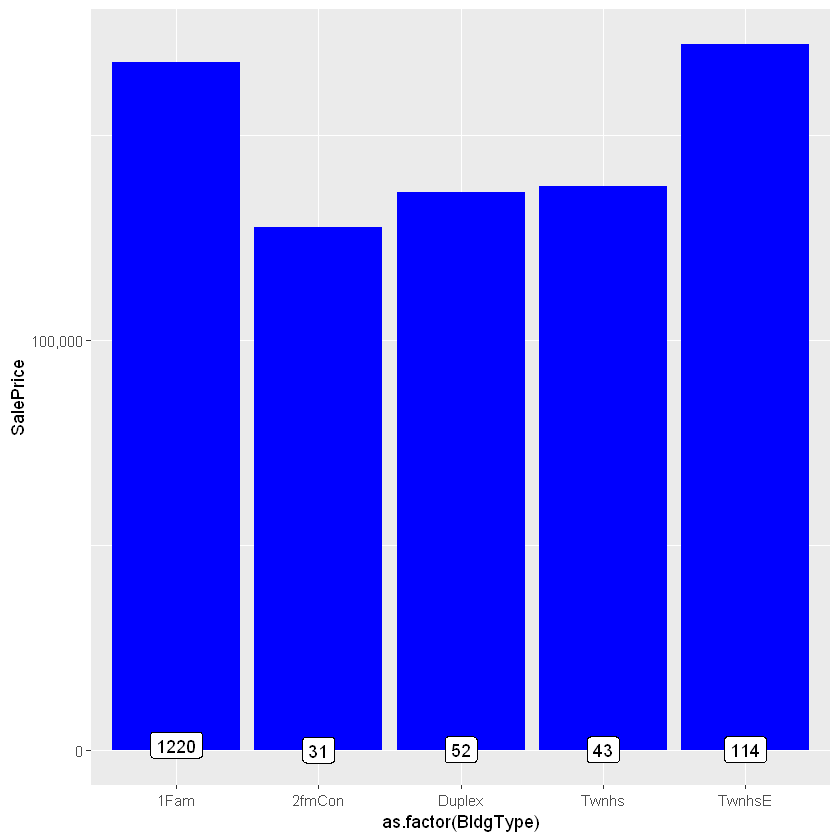

In [115]:
ggplot(all[!is.na(all$SalePrice),], aes(x=as.factor(BldgType), y=SalePrice)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue')+
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma) +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..))

In [116]:
#No ordinality, so converting into factors
all$BldgType <- as.factor(all$BldgType)
table(all$BldgType)


  1Fam 2fmCon Duplex  Twnhs TwnhsE 
  2425     62    109     96    227 

In [117]:
sum(table(all$BldgType))

[1] 2919

   1Story   One story
   1.5Fin   One and one-half story: 2nd level finished
   1.5Unf   One and one-half story: 2nd level unfinished
   2Story   Two story
   2.5Fin   Two and one-half story: 2nd level finished
   2.5Unf   Two and one-half story: 2nd level unfinished
   SFoyer   Split Foyer
   SLvl Split Level

In [118]:
#No ordinality, so converting into factors
all$HouseStyle <- as.factor(all$HouseStyle)
table(all$HouseStyle)


1.5Fin 1.5Unf 1Story 2.5Fin 2.5Unf 2Story SFoyer   SLvl 
   314     19   1471      8     24    872     83    128 

In [119]:
sum(table(all$HouseStyle))

[1] 2919

**Neighborhood and Conditions**

   Blmngtn  Bloomington Heights
   Blueste  Bluestem
   BrDale   Briardale
   BrkSide  Brookside
   ClearCr  Clear Creek
   CollgCr  College Creek
   Crawfor  Crawford
   Edwards  Edwards
   Gilbert  Gilbert
   IDOTRR   Iowa DOT and Rail Road
   MeadowV  Meadow Village
   Mitchel  Mitchell
   Names    North Ames
   NoRidge  Northridge
   NPkVill  Northpark Villa
   NridgHt  Northridge Heights
   NWAmes   Northwest Ames
   OldTown  Old Town
   SWISU    South & West of Iowa State University
   Sawyer   Sawyer
   SawyerW  Sawyer West
   Somerst  Somerset
   StoneBr  Stone Brook
   Timber   Timberland
   Veenker  Veenker

In [120]:
#No ordinality, so converting into factors
all$Neighborhood <- as.factor(all$Neighborhood)
table(all$Neighborhood)


Blmngtn Blueste  BrDale BrkSide ClearCr CollgCr Crawfor Edwards Gilbert  IDOTRR 
     28      10      30     108      44     267     103     194     165      93 
MeadowV Mitchel   NAmes NoRidge NPkVill NridgHt  NWAmes OldTown  Sawyer SawyerW 
     37     114     443      71      23     166     131     239     151     125 
Somerst StoneBr   SWISU  Timber Veenker 
    182      51      48      72      24 

In [121]:
sum(table(all$Neighborhood))

[1] 2919

   Artery   Adjacent to arterial street
   Feedr    Adjacent to feeder street   
   Norm Normal  
   RRNn Within 200' of North-South Railroad
   RRAn Adjacent to North-South Railroad
   PosN Near positive off-site feature--park, greenbelt, etc.
   PosA Adjacent to postive off-site feature
   RRNe Within 200' of East-West Railroad
   RRAe Adjacent to East-West Railroad

In [122]:
#No ordinality, so converting into factors
all$Condition1 <- as.factor(all$Condition1)
table(all$Condition1)


Artery  Feedr   Norm   PosA   PosN   RRAe   RRAn   RRNe   RRNn 
    92    164   2511     20     39     28     50      6      9 

In [123]:
sum(table(all$Condition1))

[1] 2919

In [124]:
#No ordinality, so converting into factors
all$Condition2 <- as.factor(all$Condition2)
table(all$Condition2)


Artery  Feedr   Norm   PosA   PosN   RRAe   RRAn   RRNn 
     5     13   2889      4      4      1      1      2 

In [125]:
sum(table(all$Condition2))

[1] 2919

**Pavement of Street & Driveway**

   Grvl Gravel  
   Pave Paved

In [126]:
#Ordinal, so label encoding
all$Street<-as.integer(revalue(all$Street, c('Grvl'=0, 'Pave'=1)))
table(all$Street)


   0    1 
  12 2907 

In [127]:
sum(table(all$Street))

[1] 2919

   Y    Paved 
   P    Partial Pavement
   N    Dirt/Gravel

In [128]:
#Ordinal, so label encoding
all$PavedDrive<-as.integer(revalue(all$PavedDrive, c('N'=0, 'P'=1, 'Y'=2)))
table(all$PavedDrive)


   0    1    2 
 216   62 2641 

In [129]:
sum(table(all$PavedDrive))

[1] 2919

### 5.4 Changing some numeric variables into factors

모든 변수는 NA가 없어졌고 모든 캐릭터 변수는 facor의 numeric labels로 변환됐다. 그러나 numeric이라고 나오지만 categorical이어야 하는 3개 변수가 있다.

#### 5.4.1 Year and Month Sold

YearBuilt의 ordinality는 타당하지만 (오래된 집은 가치가 떨어짐), 오직 5년 간의 매출만을 이야기 하고 있다. 이 기간은 경제 위기도 포함한다. 예를 들면 붕괴 이후인 2009년의 Sale Prices는 2007년보다 현저히 낮다. 따라서 모델링하기 전에 YrSold를 factor로 바꿀 것이다. 하지만 YrSold의 numeric 버전도 Age 변수를 만들 때 필요하기 때문에 아직은 그냥 놔둘 것이다.

Month Sold도 또한 정수형 변수이다. 그러나 12월은 1월보다 낫다는 의미가 아니다. 따라서 MoSold 값을 factors로 다시 변환할 것이다.

In [130]:
str(all$YrSold)

 int [1:2919] 2008 2007 2008 2006 2008 2009 2007 2009 2008 2008 ...


In [131]:
str(all$MoSold)

 int [1:2919] 2 5 9 2 12 10 8 11 4 1 ...


In [132]:
all$MoSold <- as.factor(all$MoSold)

예상보다는 가파르지 않지만 2007년 말에 일어난 금융 위기의 영향을 볼 수 있다. 2007년에 가장 높은 평균 가격을 보여주고 이후로 점점 하락세가 된다. 하지만 아래 그래프를 보면 계절도 중요한 영향을 미친다는 것을 알 수 있다.

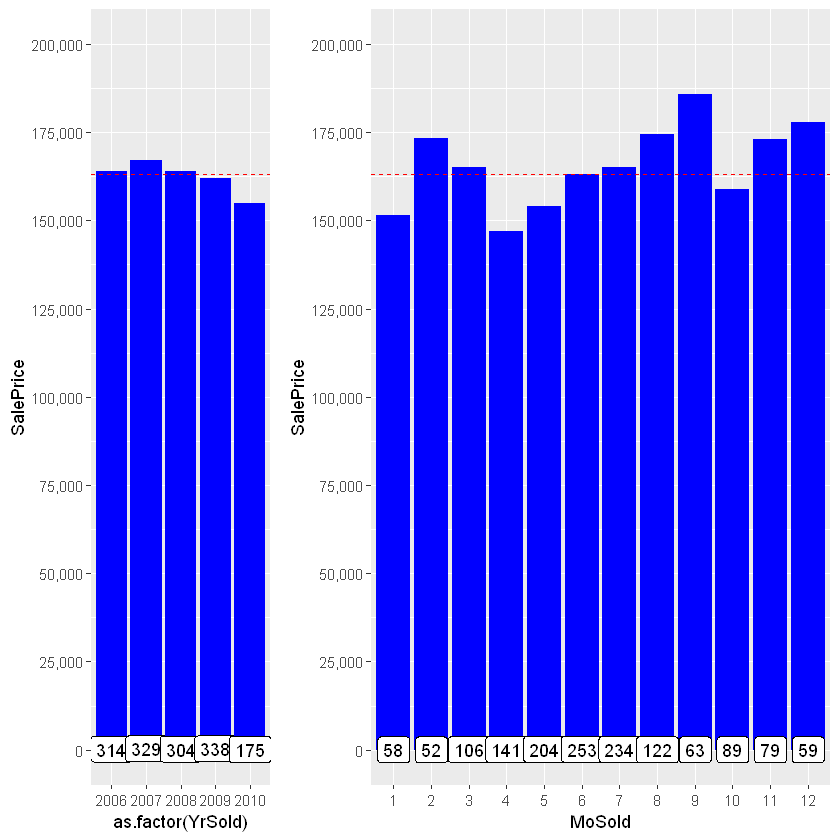

In [133]:
ys <- ggplot(all[!is.na(all$SalePrice),], aes(x=as.factor(YrSold), y=SalePrice)) +
geom_bar(stat='summary', fun.y = "median", fill='blue')+
scale_y_continuous(breaks= seq(0, 800000, by=25000), labels = comma) +
geom_label(stat = "count", aes(label = ..count.., y = ..count..)) +
coord_cartesian(ylim = c(0, 200000)) +
geom_hline(yintercept=163000, linetype="dashed", color="red") #dashed line is median SalePrice
ms <- ggplot(all[!is.na(all$SalePrice),], aes(x=MoSold, y=SalePrice)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue')+
        scale_y_continuous(breaks= seq(0, 800000, by=25000), labels = comma) +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..)) +
        coord_cartesian(ylim = c(0, 200000)) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice

grid.arrange(ys, ms, widths=c(1,2))

#### 5.4.2 MSSubClass

MSSubClass: Identifies the type of dwelling involved in the sale

    20  1-STORY 1946 & NEWER ALL STYLES
    30  1-STORY 1945 & OLDER
    40  1-STORY W/FINISHED ATTIC ALL AGES
    45  1-1/2 STORY - UNFINISHED ALL AGES
    50  1-1/2 STORY FINISHED ALL AGES
    60  2-STORY 1946 & NEWER
    70  2-STORY 1945 & OLDER
    75  2-1/2 STORY ALL AGES
    80  SPLIT OR MULTI-LEVEL
    85  SPLIT FOYER
    90  DUPLEX - ALL STYLES AND AGES
   120  1-STORY PUD (Planned Unit Development) - 1946 & NEWER
   150  1-1/2 STORY PUD - ALL AGES
   160  2-STORY PUD - 1946 & NEWER
   180  PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
   190  2 FAMILY CONVERSION - ALL STYLES AND AGES

이 클래스들은 수로 나오지만 실제로는 categories이다.

In [134]:
str(all$MSSubClass)

 int [1:2919] 60 20 60 70 60 50 20 60 50 190 ...


In [135]:
all$MSSubClass <- as.factor(all$MSSubClass)

In [136]:
#revalue for better readability
all$MSSubClass<-revalue(all$MSSubClass, c('20'='1 story 1946+', '30'='1 story 1945-', '40'='1 story unf attic', '45'='1,5 story unf', '50'='1,5 story fin', '60'='2 story 1946+', '70'='2 story 1945-', '75'='2,5 story all ages', '80'='split/multi level', '85'='split foyer', '90'='duplex all style/age', '120'='1 story PUD 1946+', '150'='1,5 story PUD all', '160'='2 story PUD 1946+', '180'='PUD multilevel', '190'='2 family conversion'))

In [137]:
str(all$MSSubClass)

 Factor w/ 16 levels "1 story 1946+",..: 6 1 6 7 6 5 1 6 5 16 ...


## 6 Visualization of important variables

이제 모든 캐릭터 변수들이 categorical factors 또는 label화된 숫자로 변환되었다. 또한, 3개의 numeric 변수들이 factors로 변환되었고 Utilities 변수를 삭제했다. 아래르 보면 알 수 있듯, numerical variables는 현재 56개이며 23개가 categorical 변수이다.

In [138]:
numericVars <- which(sapply(all, is.numeric)) #index vector numeric variables
factorVars <- which(sapply(all, is.factor)) #index vector factor variables
cat('There are', length(numericVars), 'numeric varariables, and', length(factorVars), 'categoric variables')

There are 56 numeric varariables, and 23 categoric variables

### 6.1 Correlations again

아래에서 상관 관계를 다시 확인해보겠다. SalePrice와 적어도 0.5이상의 상관 관계를 보이는 변수의 개수가 10개(4.2.1)에서 16개로 증가했다.

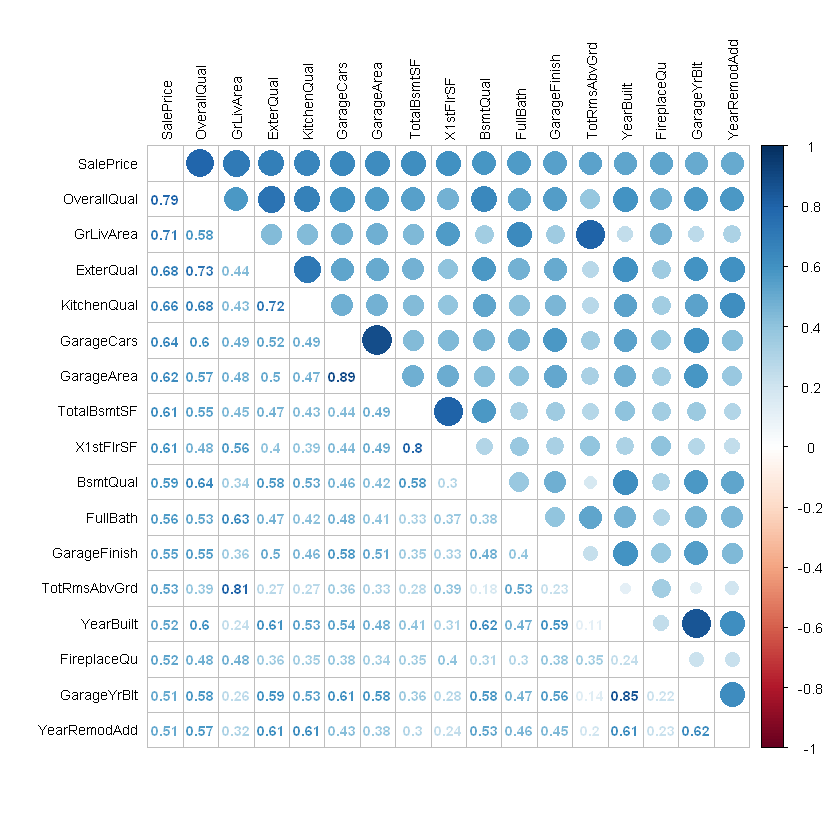

In [139]:
all_numVar <- all[, numericVars]
cor_numVar <- cor(all_numVar, use="pairwise.complete.obs") #correlations of all numeric variables

#sort on decreasing correlations with SalePrice
cor_sorted <- as.matrix(sort(cor_numVar[,'SalePrice'], decreasing = TRUE))
#select only high corelations
CorHigh <- names(which(apply(cor_sorted, 1, function(x) abs(x)>0.5)))
cor_numVar <- cor_numVar[CorHigh, CorHigh]
                             
corrplot.mixed(cor_numVar, tl.col="black", tl.pos = "lt", tl.cex = 0.7, cl.cex = .7, number.cex=.7)

### 6.2 Finding variable importance with a quick Random Forest

앞에서 본 상관 관계를 통해 대략적으로 가장 중요한 numeric 변수와 다중공선성을 알 수 있었지만 이번엔 categorical 변수를 포함해서 가장 중요한 변수가 뭔지 보려고 한다.

패키지의 calc.relimp function을 사용해서 퀵 선형 회귀 모델로 변수의 상대적 중요성을 얻으려고 했으며 boruta function을 이용하여 중요한 그룹과 아닌 그룹으로 변수를 나누려고 했다. 하지만 이 방법은 시간이 오래 걸렸다. 그렇지만 변수의 중요성 지표를 원했기 때문에 단순하게 유지하기로 결정해서 100개의 트리를 가진 빠르지만 더러운 랜덤 포레스트를 쓰기로 했다. 상대적으로 작은 트리를 규정하면 그렇게 오랜 시간이 걸리지도 않고 잘 작동한다.

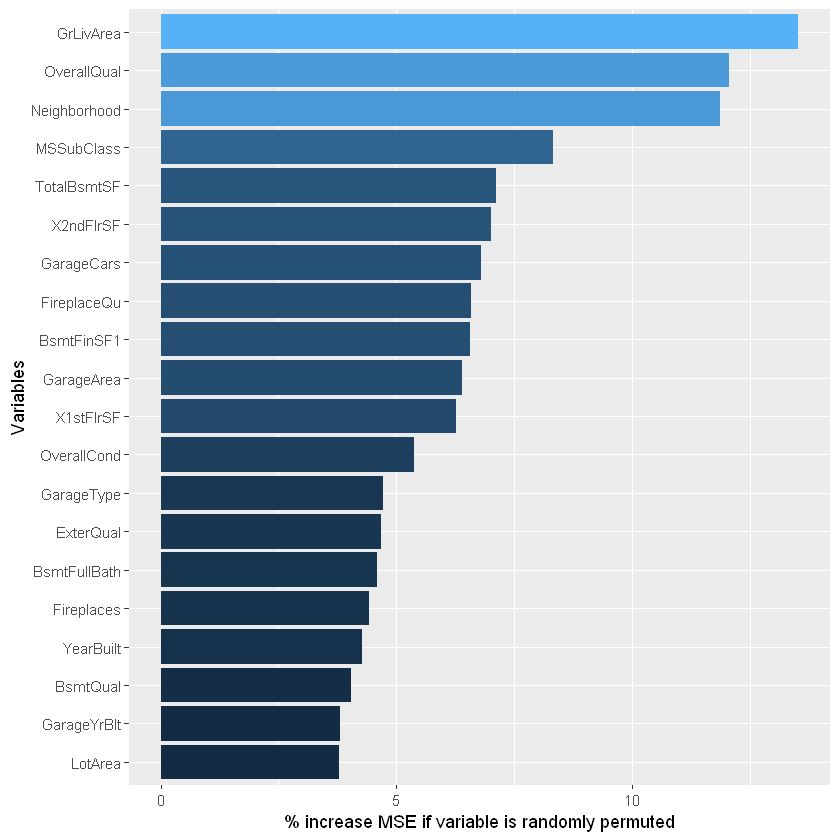

In [140]:
set.seed(2018)
quick_RF <- randomForest(x=all[1:1460,-79], y=all$SalePrice[1:1460], ntree=100,importance=TRUE)
imp_RF <- importance(quick_RF)
imp_DF <- data.frame(Variables = row.names(imp_RF), MSE = imp_RF[,1])
imp_DF <- imp_DF[order(imp_DF$MSE, decreasing = TRUE),]

ggplot(imp_DF[1:20,], aes(x=reorder(Variables, MSE), y=MSE, fill=MSE)) + geom_bar(stat = 'identity') + labs(x = 'Variables', y= '% increase MSE if variable is randomly permuted') + coord_flip() + theme(legend.position="none")

RF에 따르면 가장 중요한 categorical 변수는 Neighborhood, MSSubClass, and GarageType이다.

** 커널과 결과가 다른데..???

#### 6.2.1 Above Gound Living Area, and other surface related variables (in square feet)

처음에 Above Ground Living Area와 SalePrice의 관계를 보여줬는데 지금부터는 분포를 보려고 한다. Top 20에 '평방 피트' 표면 측정 방식이 많았기에 이 섹션에서 묶어보려고 한다. <br>참고: GarageArea는 Garage variables 섹션에서 다뤘다.

Above Ground Living Area와 높은 상관 관계에 엤는 ‘Total Rooms Above Ground’ (TotRmsAbvGrd) 를 추가했다 (0.81).

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


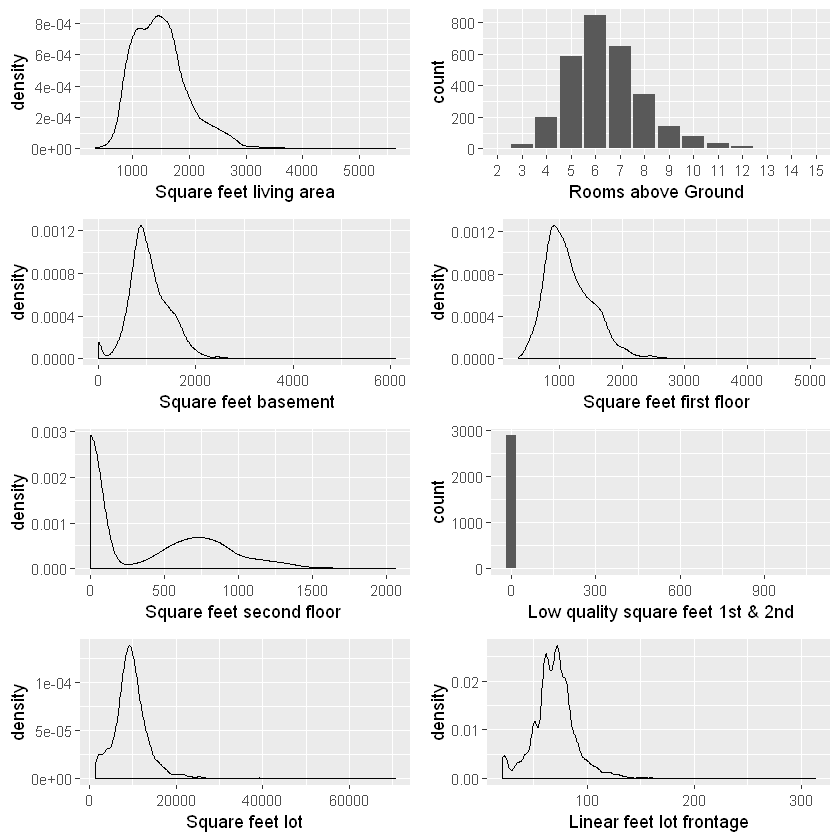

In [141]:
s1 <- ggplot(data= all, aes(x=GrLivArea)) +
        geom_density() + labs(x='Square feet living area')
s2 <- ggplot(data=all, aes(x=as.factor(TotRmsAbvGrd))) +
        geom_histogram(stat='count') + labs(x='Rooms above Ground')
s3 <- ggplot(data= all, aes(x=X1stFlrSF)) +
        geom_density() + labs(x='Square feet first floor')
s4 <- ggplot(data= all, aes(x=X2ndFlrSF)) +
        geom_density() + labs(x='Square feet second floor')
s5 <- ggplot(data= all, aes(x=TotalBsmtSF)) +
        geom_density() + labs(x='Square feet basement')
s6 <- ggplot(data= all[all$LotArea<100000,], aes(x=LotArea)) +
        geom_density() + labs(x='Square feet lot')
s7 <- ggplot(data= all, aes(x=LotFrontage)) +
        geom_density() + labs(x='Linear feet lot frontage')
s8 <- ggplot(data= all, aes(x=LowQualFinSF)) +
        geom_histogram() + labs(x='Low quality square feet 1st & 2nd')

layout <- matrix(c(1,2,5,3,4,8,6,7),4,2,byrow=TRUE)
multiplot(s1, s2, s3, s4, s5, s6, s7, s8, layout=layout)

이 변수들의 outliers는 나중에 보도록 하겠다. 시각화를 위해 100,000 평방 피트 이상의 집들은 뺐다. (4채).

GrLivArea는 1층과 2층의 평수의 합이다. 그러나 LowQualFinSF: Low quality finished square feet (all floors)라는 변수가 있다는 것을 알았다. 위 그래프를 보면 알 수 있듯이, 거의 모든 집이 LowQualFinSF를 갖고 있지 않다. (40채만이 갖고 있음). 이 말은 GrLivArea 안에 평방 피트가 포함되어있다는 것을 의미한다. 이 3변수와 GrLivArea의 상관 관계는 1이다.

In [142]:
cor(all$GrLivArea, (all$X1stFlrSF + all$X2ndFlrSF + all$LowQualFinSF))

[1] 1

In [143]:
head(all[all$LowQualFinSF>0, c('GrLivArea', 'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF')])

,GrLivArea,X1stFlrSF,X2ndFlrSF,LowQualFinSF
52,1176,816,0,360
89,1526,1013,0,513
126,754,520,0,234
171,1382,854,0,528
186,3608,1518,1518,572
188,1656,808,704,144


#### 6.2.2 The most important categorical variable; Neighborhood

첫번째 그래프는 Neighorhood에 의한 SalePrice의 평균을 보여준다. train set에서의 각 Neighborhood 당 frequency(number of houses)는 label에서 보여준다.

두 번째 그래프는 모든 데이터에서의 frequencies를 보여준다.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

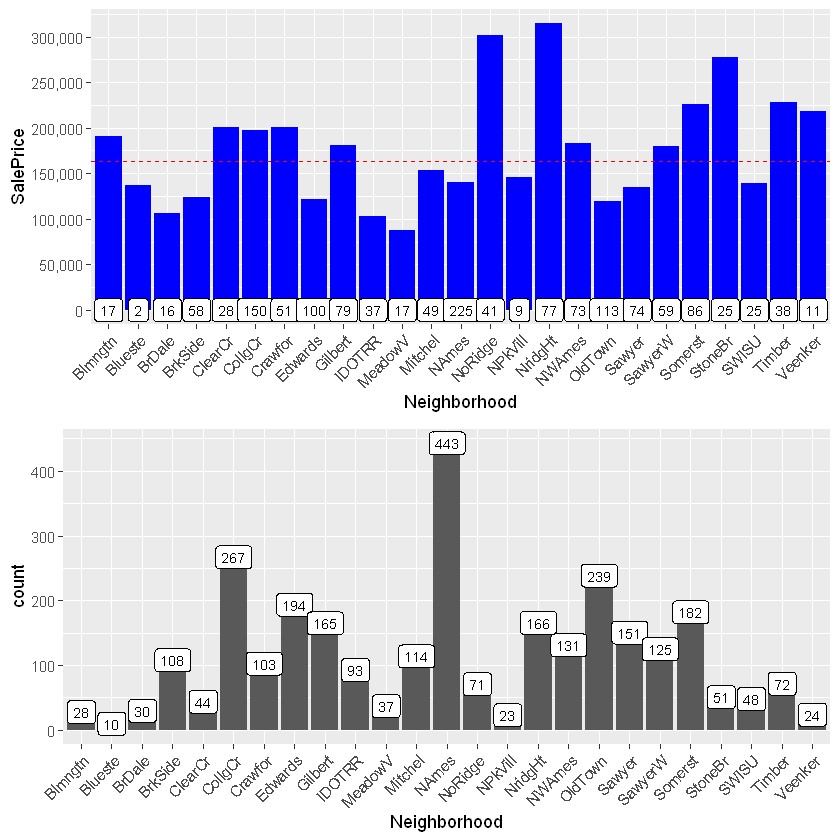

In [144]:
n1 <- ggplot(all[!is.na(all$SalePrice),], aes(x=Neighborhood, y=SalePrice)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=50000), labels = comma) +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..), size=3) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice
n2 <- ggplot(data=all, aes(x=Neighborhood)) +
        geom_histogram(stat='count')+
        geom_label(stat = "count", aes(label = ..count.., y = ..count..), size=3)+
        theme(axis.text.x = element_text(angle = 45, hjust = 1))
grid.arrange(n1, n2)

#### 6.2.3 Overall Quality, and other Quality variables

Overall Quality와 SalePrice의 관계를 시각화했었는데 frequency 분배도 보고 싶었다.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

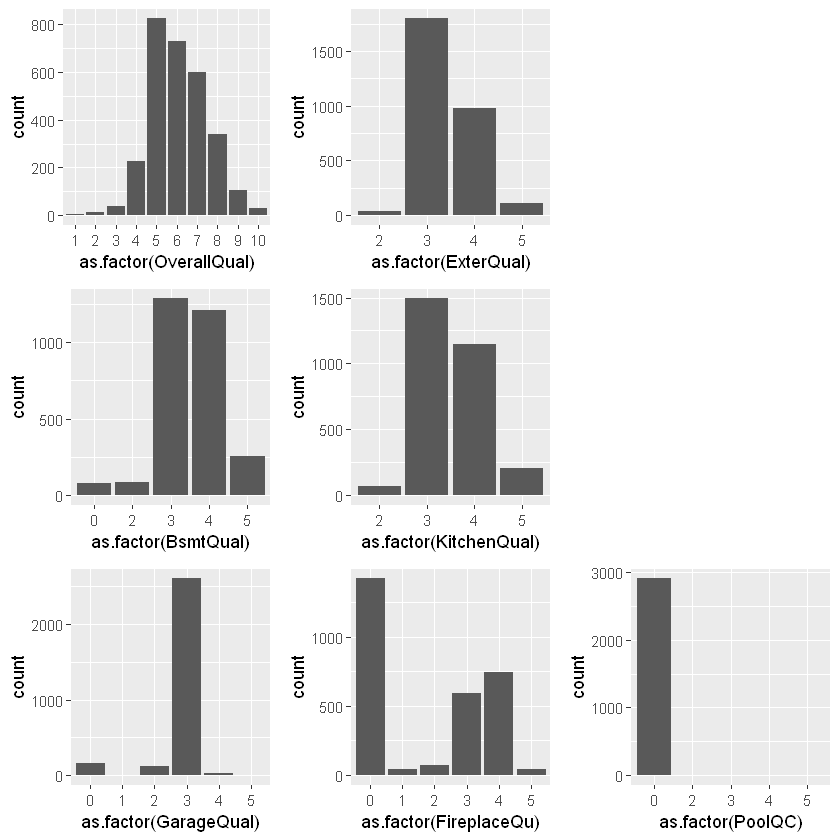

In [145]:
q1 <- ggplot(data=all, aes(x=as.factor(OverallQual))) +
        geom_histogram(stat='count')
q2 <- ggplot(data=all, aes(x=as.factor(ExterQual))) +
        geom_histogram(stat='count')
q3 <- ggplot(data=all, aes(x=as.factor(BsmtQual))) +
        geom_histogram(stat='count')
q4 <- ggplot(data=all, aes(x=as.factor(KitchenQual))) +
        geom_histogram(stat='count')
q5 <- ggplot(data=all, aes(x=as.factor(GarageQual))) +
        geom_histogram(stat='count')
q6 <- ggplot(data=all, aes(x=as.factor(FireplaceQu))) +
        geom_histogram(stat='count')
q7 <- ggplot(data=all, aes(x=as.factor(PoolQC))) +
        geom_histogram(stat='count')

layout <- matrix(c(1,2,8,3,4,8,5,6,7),3,3,byrow=TRUE)
multiplot(q1, q2, q3, q4, q5, q6, q7, layout=layout)

Overall Quality는 매우 중요하고 다른 변수들보다 더 세분화되어 있다. External Quality도 중요하지만 Overall Quality와 높은 상관 관계를 가진다(0.73). Kitchen Quality도 모든 집이 주방을 갖고 있고 어떤 substance와 편향값이 있어서 봐두면 좋다. GarageQuality는 차이를 별로 보이지 않으며 다수의 garages는 Q3를 갖고 있다. Fireplace Quality는 높은 상관 관계를 가지고 중요한 변수들의 list이다. PoolQC는 매우 희소하다(13개의 pools는 이 사이즈에서 보이지도 않는다). 나중에 'has pool' 변수를 만들어서 봐야겠다.

#### 6.2.4 The second most important categorical variable; MSSubClass

첫 시각화에서 보여주는 건 MSSubClass에 의한 SalePrice이다.
히스토그램은 모든 데이터에서의 frequencies를 보여준다. 대부분의 집은 상대적으로 새 집이고 하나 혹은 두 개의 층을 가지고 있다.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

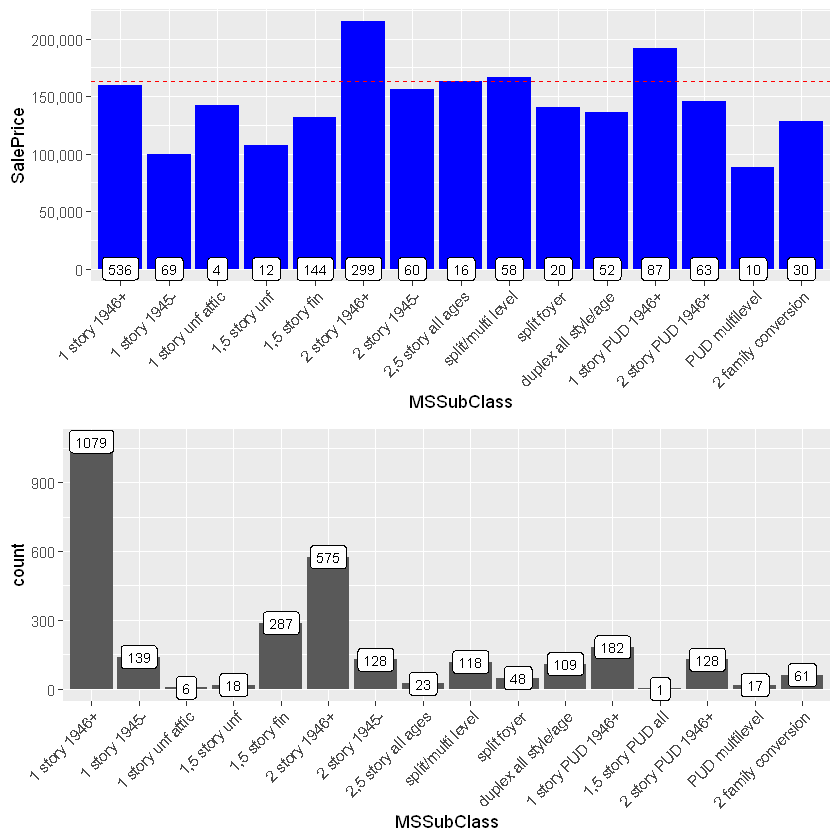

In [146]:
ms1 <- ggplot(all[!is.na(all$SalePrice),], aes(x=MSSubClass, y=SalePrice)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=50000), labels = comma) +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..), size=3) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice
ms2 <- ggplot(data=all, aes(x=MSSubClass)) +
        geom_histogram(stat='count')+
        geom_label(stat = "count", aes(label = ..count.., y = ..count..), size=3) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))
grid.arrange(ms1, ms2)

#### 6.2.5 Garage variables

몇몇 Garage variables는 SalePrice와 높은 상관 관계에 있고 퀵 랜덤 포레스트 top-20리스트에 있었다. 그러나 다중공선성이 있어 7개의 garage 변수는 너무 많다고 생각한다. 3개 정도면 충분하다고 생각하지만 (아마 GarageCars, GarageType, and a Quality measurement) 그 전에 먼저 시각화를 해보겠다.

In [147]:
#correct error
all$GarageYrBlt[2593] <- 2007 #this must have been a typo. GarageYrBlt=2207, YearBuilt=2006, YearRemodAdd=2007.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


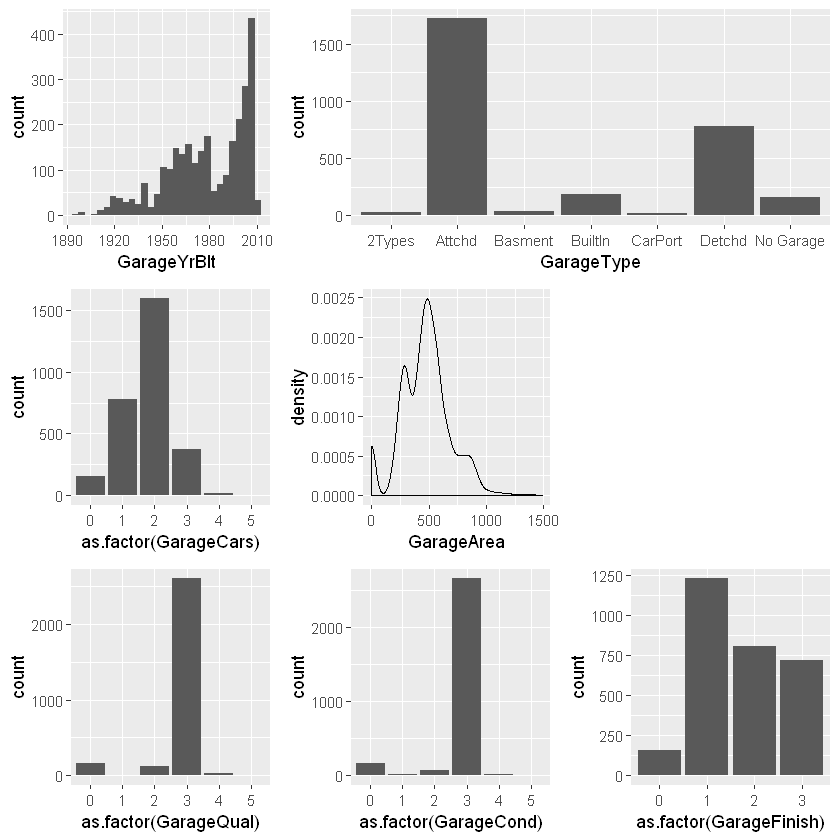

In [148]:
g1 <- ggplot(data=all[all$GarageCars !=0,], aes(x=GarageYrBlt)) +
        geom_histogram()
g2 <- ggplot(data=all, aes(x=as.factor(GarageCars))) +
        geom_histogram(stat='count')
g3 <- ggplot(data= all, aes(x=GarageArea)) +
        geom_density()
g4 <- ggplot(data=all, aes(x=as.factor(GarageCond))) +
        geom_histogram(stat='count')
g5 <- ggplot(data=all, aes(x=GarageType)) +
        geom_histogram(stat='count')
g6 <- ggplot(data=all, aes(x=as.factor(GarageQual))) +
        geom_histogram(stat='count')
g7 <- ggplot(data=all, aes(x=as.factor(GarageFinish))) +
        geom_histogram(stat='count')

layout <- matrix(c(1,5,5,2,3,8,6,4,7),3,3,byrow=TRUE)
multiplot(g1, g2, g3, g4, g5, g6, g7, layout=layout)

4.2에서도 말했듯이 GarageCars와 GarageArea는 상관 관계가 높다. 또한, GarageQual와 GarageCond도 상관 관계가 높은 듯이 보인다.

#### 6.2.6 Basement variables

garage 변수와 비슷하게, 많은 basement 변수가 상관 관계 매트릭스와 Top 20 RF 예측 리스트에서 중요했다. 그러나 11개의 basement 변수는 너무 많다고 생각한다. basement 변수를 가지고 뭐할지 결정하기 전에 아래에 8개를 시각화해보겠다. 그 중 "Bathroom" 변수는 Feature Engineering (section 7.1)에서 다루고 "Basement square feet"은 이미 6.2.1에서 다뤘다.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


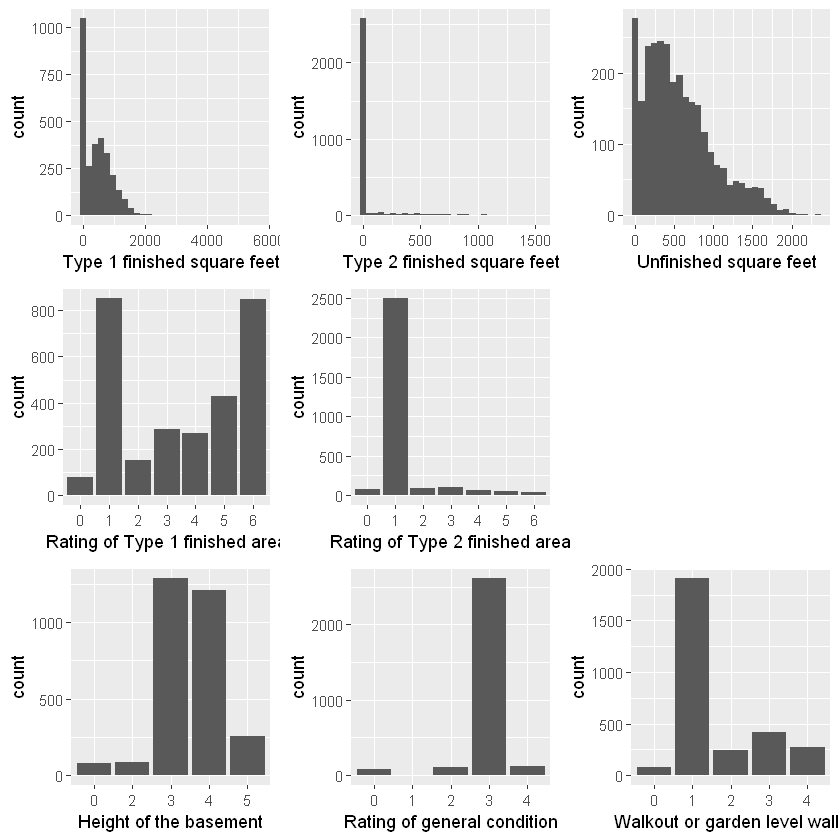

In [149]:
b1 <- ggplot(data=all, aes(x=BsmtFinSF1)) +
        geom_histogram() + labs(x='Type 1 finished square feet')
b2 <- ggplot(data=all, aes(x=BsmtFinSF2)) +
        geom_histogram()+ labs(x='Type 2 finished square feet')
b3 <- ggplot(data=all, aes(x=BsmtUnfSF)) +
        geom_histogram()+ labs(x='Unfinished square feet')
b4 <- ggplot(data=all, aes(x=as.factor(BsmtFinType1))) +
        geom_histogram(stat='count')+ labs(x='Rating of Type 1 finished area')
b5 <- ggplot(data=all, aes(x=as.factor(BsmtFinType2))) +
        geom_histogram(stat='count')+ labs(x='Rating of Type 2 finished area')
b6 <- ggplot(data=all, aes(x=as.factor(BsmtQual))) +
        geom_histogram(stat='count')+ labs(x='Height of the basement')
b7 <- ggplot(data=all, aes(x=as.factor(BsmtCond))) +
        geom_histogram(stat='count')+ labs(x='Rating of general condition')
b8 <- ggplot(data=all, aes(x=as.factor(BsmtExposure))) +
        geom_histogram(stat='count')+ labs(x='Walkout or garden level walls')

layout <- matrix(c(1,2,3,4,5,9,6,7,8),3,3,byrow=TRUE)
multiplot(b1, b2, b3, b4, b5, b6, b7, b8, layout=layout)

TotalBsmtSF는 finished area와 unfinished area로 나뉘었따. 이 3변수와 TotalBsmtSF 사이의 상관 관계를 체크했다. 상관 관계는 정확히 1이었다.

Basement Quality는 지하실의 길이를 측정하는 거라고 밝혀졌기 때문에 변수 이름이 조금 이상한 것 같다.

## Feature engineering

### 7.1 Total number of Bathrooms

4개의 bathroom 변수가 있다. 개인적으로 이 변수들은 중요하지 않다고 생각한다. 그러나 이 변수들을 예측 변수에 추가한다면 강해질 거라고 가정했다.

"파우더 룸 또는 게스트 욕조가 있는 걸로 알려져 있는 A half-bath는 화장실 구성 요소(변기와 세면대) 중 두 가지만 포함하고 있다. 따라서 half bathrooms도 half로 세겠다.

In [150]:
all$TotBathrooms <- all$FullBath + (all$HalfBath*0.5) + all$BsmtFullBath + (all$BsmtHalfBath*0.5)

첫 번째 그래프를 보면 명확한 상관 관계를 보여주고 있다(0.63). 모든 데이터에서의 Bathrooms의 frequency 분배는 두 번째 그래프에 나와있다.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

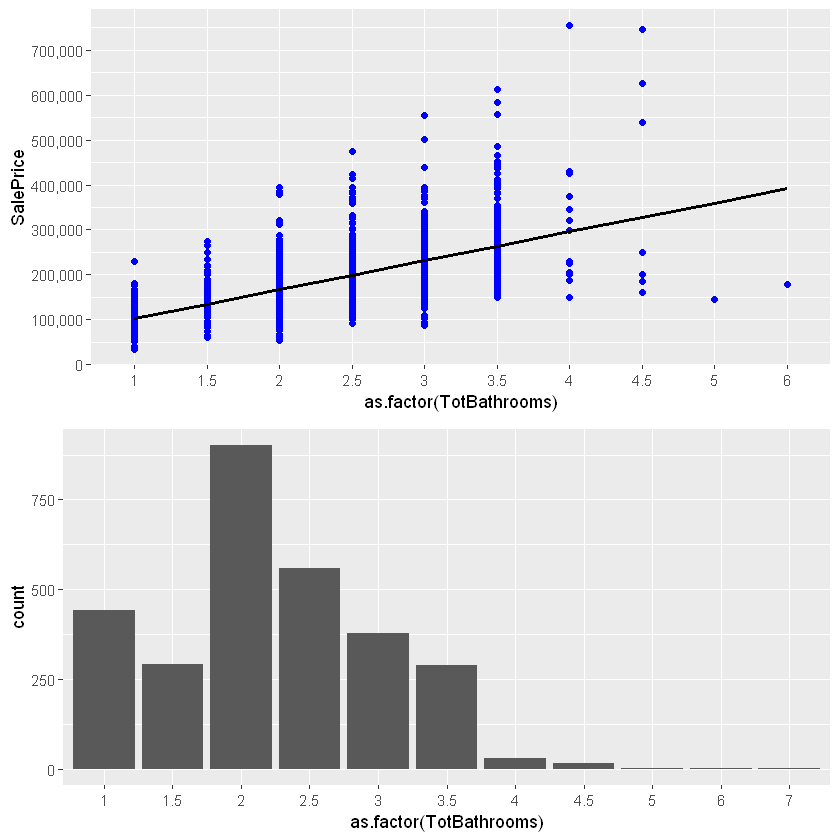

In [151]:
tb1 <- ggplot(data=all[!is.na(all$SalePrice),], aes(x=as.factor(TotBathrooms), y=SalePrice))+
        geom_point(col='blue') + geom_smooth(method = "lm", se=FALSE, color="black", aes(group=1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma)
tb2 <- ggplot(data=all, aes(x=as.factor(TotBathrooms))) +
        geom_histogram(stat='count')
grid.arrange(tb1, tb2)

### 7.2 Adding ‘House Age’, ‘Remodeled (Yes/No)’, and IsNew variables

집의 연식에 관련된 변수는 3가지가 있다: YearBlt, YearRemodAdd, and YearSold. YearRemodAdds는 리모델링을 하지 않았으면 YearBuilt의 디폴트 값이다. Age를 결정하기 위해 YearRemodeled과 YearSold를 이용할 것이다. 하지만 오래된 건축물의 일부분은 남아있으며 리모델링을 해도 남아 있는 부부분이 있기 때문에 리모델링 Yes/No 변수도 제시하려고 한다. Age가 리모델링된 날을 기반으로 한다면 같은 년도에 지어진 집보다 가치가 낮다고 볼 수 있기에 penalty parameter로 봐야할 것이다.

In [152]:
all$Remod <- ifelse(all$YearBuilt==all$YearRemodAdd, 0, 1) #0=No Remodeling, 1=Remodeling
all$Age <- as.numeric(all$YrSold)-all$YearRemodAdd

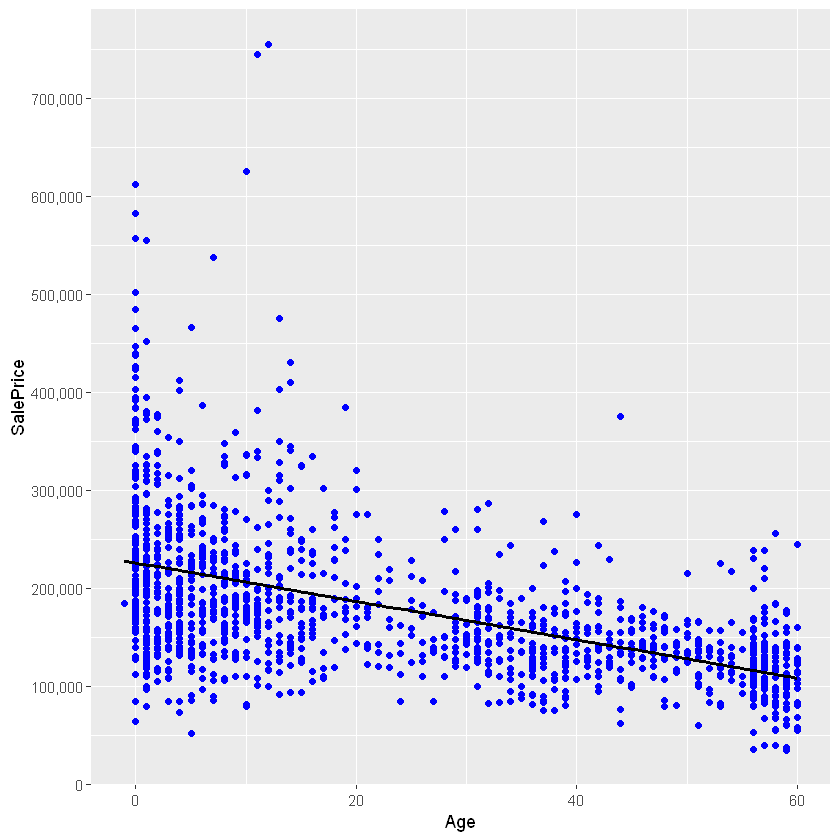

In [153]:
ggplot(data=all[!is.na(all$SalePrice),], aes(x=Age, y=SalePrice))+
        geom_point(col='blue') + geom_smooth(method = "lm", se=FALSE, color="black", aes(group=1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

예측한 대로 그래프는 Age와 negative하다. (오래된 집은 가치가 낮음)

In [154]:
cor(all$SalePrice[!is.na(all$SalePrice)], all$Age[!is.na(all$SalePrice)])

[1] -0.5090787

또한 아래를 보면 예상한 대로 리모델링된 집도 가치가 낮다.

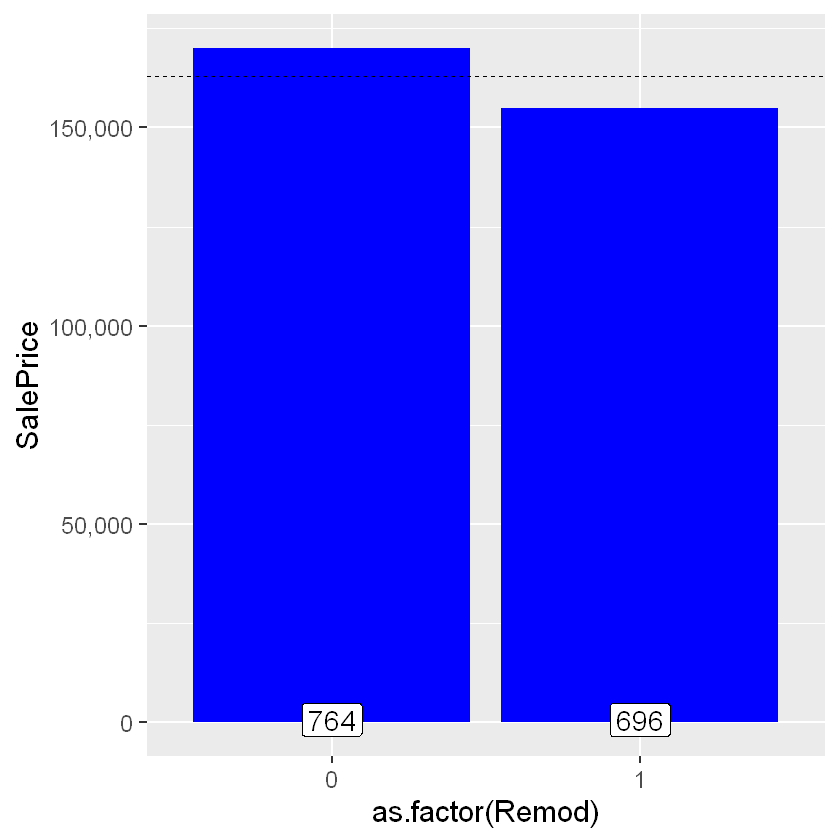

In [155]:
ggplot(all[!is.na(all$SalePrice),], aes(x=as.factor(Remod), y=SalePrice)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..), size=6) +
        scale_y_continuous(breaks= seq(0, 800000, by=50000), labels = comma) +
        theme_grey(base_size = 18) +
        geom_hline(yintercept=163000, linetype="dashed") #dashed line is median SalePrice

마지막으로 IsNew 변수를 만들었다. 종합해보면 dataset에는 116채의 새 집이 있다.

In [156]:
all$IsNew <- ifelse(all$YrSold==all$YearBuilt, 1, 0)
table(all$IsNew)


   0    1 
2803  116 

이 116채의 집은 train과 data set에 균등하게 분포되어 있기 때문에 새 집은 평균보다 상당히 가치가 있다.

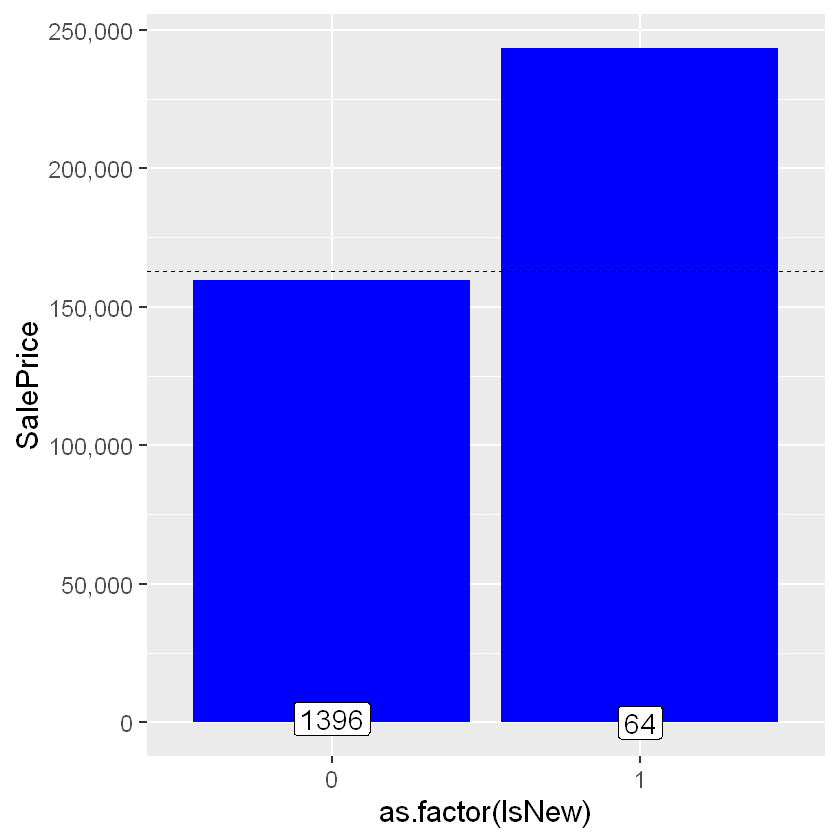

In [157]:
ggplot(all[!is.na(all$SalePrice),], aes(x=as.factor(IsNew), y=SalePrice)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..), size=6) +
        scale_y_continuous(breaks= seq(0, 800000, by=50000), labels = comma) +
        theme_grey(base_size = 18) +
        geom_hline(yintercept=163000, linetype="dashed") #dashed line is median SalePrice

In [158]:
all$YrSold <- as.factor(all$YrSold) #the numeric version is now not needed anymore

### 7.3 Binning Neighborhood

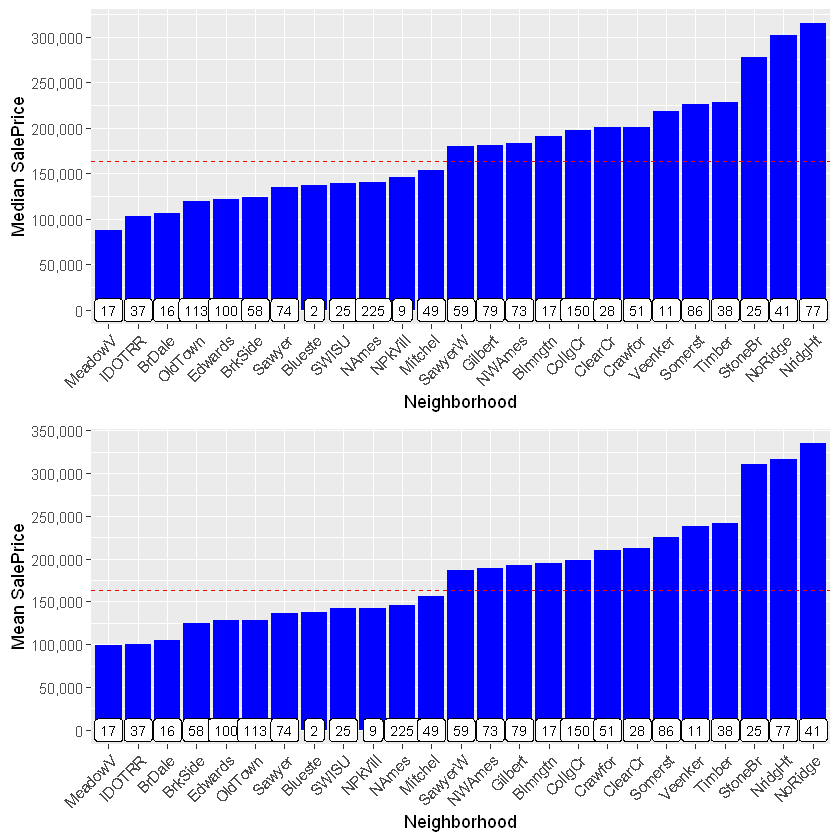

In [159]:
nb1 <- ggplot(all[!is.na(all$SalePrice),], aes(x=reorder(Neighborhood, SalePrice, FUN=median), y=SalePrice)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') + labs(x='Neighborhood', y='Median SalePrice') +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=50000), labels = comma) +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..), size=3) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice
nb2 <- ggplot(all[!is.na(all$SalePrice),], aes(x=reorder(Neighborhood, SalePrice, FUN=mean), y=SalePrice)) +
        geom_bar(stat='summary', fun.y = "mean", fill='blue') + labs(x='Neighborhood', y="Mean SalePrice") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=50000), labels = comma) +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..), size=3) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice
grid.arrange(nb1, nb2)

Saleprices의 평균과 중앙값 그래프는 3 neighborhoods가 상당히 높은 saleprices라는 것을 보여준다. 상대적으로 가난한 세 neighborhoods는 명확한 차이는 안 나지만 적어도 두 그래프 다 셋이 가난하다는 것을 보여준다. 'overbin'은 원하지 않아서 'extremes'으로 카테고리를 만들었다.

In [160]:
all$NeighRich[all$Neighborhood %in% c('StoneBr', 'NridgHt', 'NoRidge')] <- 2
all$NeighRich[!all$Neighborhood %in% c('MeadowV', 'IDOTRR', 'BrDale', 'StoneBr', 'NridgHt', 'NoRidge')] <- 1
all$NeighRich[all$Neighborhood %in% c('MeadowV', 'IDOTRR', 'BrDale')] <- 0

In [161]:
table(all$NeighRich)


   0    1    2 
 160 2471  288 

### 7.4 Total Square Feet

living place는 일반적으로 집을 살 때 중요한 요소이기 때문에 예측 변수로 추가했다.

In [162]:
all$TotalSqFeet <- all$GrLivArea + all$TotalBsmtSF

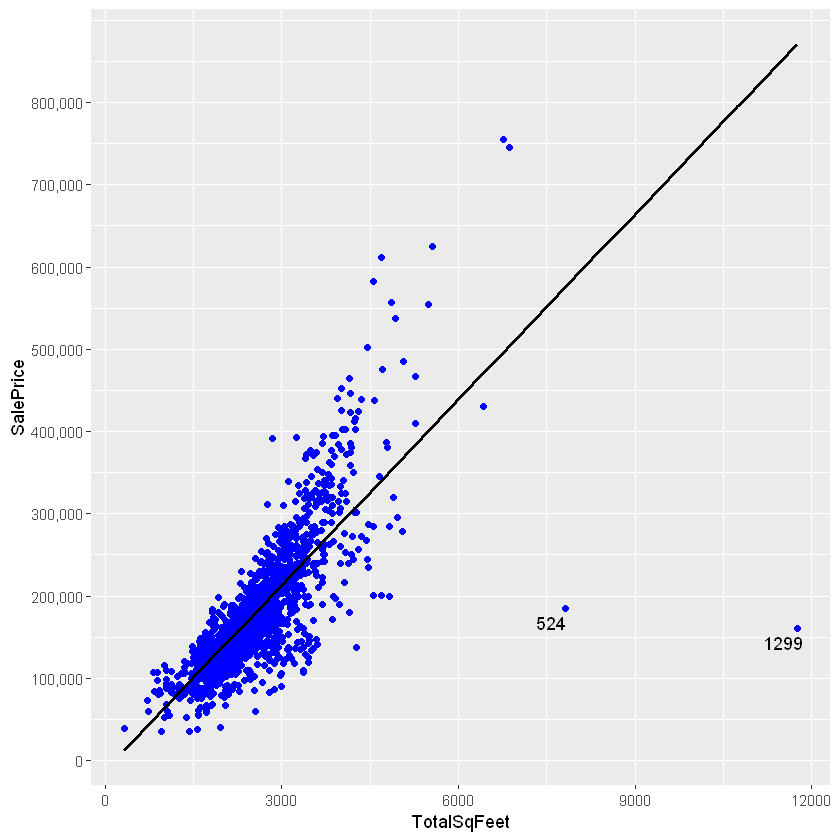

In [163]:
ggplot(data=all[!is.na(all$SalePrice),], aes(x=TotalSqFeet, y=SalePrice))+
        geom_point(col='blue') + geom_smooth(method = "lm", se=FALSE, color="black", aes(group=1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma) +
        geom_text_repel(aes(label = ifelse(all$GrLivArea[!is.na(all$SalePrice)]>4500, rownames(all), '')))

예측한 대로 SalePrice와의 상관 관계는 크다 (0.78).

In [164]:
cor(all$SalePrice, all$TotalSqFeet, use= "pairwise.complete.obs")

[1] 0.7789588

두 outliers는 전보다 더 벗어나있다. 저 두 outliers를 빼면 상관 관계가 5% 오른다.

In [165]:
cor(all$SalePrice[-c(524, 1299)], all$TotalSqFeet[-c(524, 1299)], use= "pairwise.complete.obs")

[1] 0.829042

### 7.5 Consolidating Porch variables

porch와 관련된 변수들을 나열해보았다.
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet

내가 아는 바로는 porch는 비바람이 들이치지 않는 집 밖의 장소를 말하는 걸로 알고 있기에 wooden deck은 그렇지 않아서 WoodDeckSF만 남겨 놓고 4개의 porch 변수만 연결하기로 했다.

In [166]:
all$TotalPorchSF <- all$OpenPorchSF + all$EnclosedPorch + all$X3SsnPorch + all$ScreenPorch

비록 Porch area를 다 합쳤지만 SalePrice와의 상관 관계는 강하지 않다.

In [167]:
cor(all$SalePrice, all$TotalPorchSF, use= "pairwise.complete.obs")

[1] 0.1957389

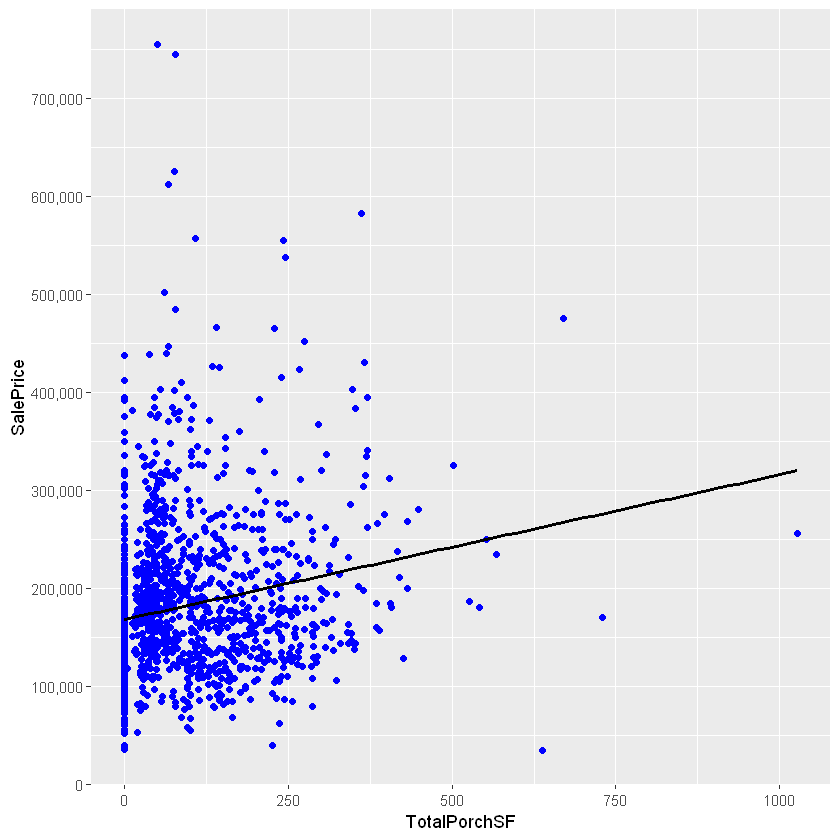

In [168]:
ggplot(data=all[!is.na(all$SalePrice),], aes(x=TotalPorchSF, y=SalePrice))+
        geom_point(col='blue') + geom_smooth(method = "lm", se=FALSE, color="black", aes(group=1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

## Preparing data for modeling

### 8.1 Dropping highly correlated variables

두 가지가 변수가 매우 높은 상관 관계에 있으면 빼려고 한다. 상관 관계 짝을 찾기 위해 6.1에서 사용했던 상관 관계 매트릭스를 사용했다. 예를 들면  GarageCars와 GarageArea는 0.89의 상관 관계였다. 둘 중에서 SalePrice와 낮은 상관 관계에 있던 변수를 뺐다. (GarageArea-0.62, GarageCars-0.64)

In [169]:
dropVars <- c('YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'TotalBsmtSF', 'TotalRmsAbvGrd', 'BsmtFinSF1')

all <- all[,!(names(all) %in% dropVars)]

### 8.2 Removing outliers

시간 측면에서 간단하게 유지하고 싶기에 SalePrice가 낮은 두 채의 큰 집을 빼도록 하겠다. 이것에 대해서는 나중에 outliers package를 이용해 더 조사하도록 하겠다.

In [170]:
all <- all[-c(524, 1299),]

### 8.3 PreProcessing predictor variables

모델링 하기 전에 'true numeric' 예측 변수를 조정하고 확장해야 한다(표에 있는 변수는 제외). 또한, categorical 예측 변수에 더미 변수를 만들어야 한다. 아래에서 dataframe을 numeric 변수와 ordinal factors로 나눴다.

In [171]:
numericVarNames <- numericVarNames[!(numericVarNames %in% c('MSSubClass', 'MoSold', 'YrSold', 'SalePrice', 'OverallQual', 'OverallCond'))] #numericVarNames was created before having done anything
numericVarNames <- append(numericVarNames, c('Age', 'TotalPorchSF', 'TotBathrooms', 'TotalSqFeet'))

DFnumeric <- all[, names(all) %in% numericVarNames]

DFfactors <- all[, !(names(all) %in% numericVarNames)]
DFfactors <- DFfactors[, names(DFfactors) != 'SalePrice']

cat('There are', length(DFnumeric), 'numeric variables, and', length(DFfactors), 'factor variables')

There are 30 numeric variables, and 49 factor variables

#### 8.3.1 Skewness and normalizing of the numeric predictors

Skewness는 분포에서 대칭을 측정하는 것을 말한다. 대칭성이 있는 dataset은 skewness가 0와 동등하다. 따라서 정규 분포에선 skewness가 0이다. Skewness는 두 tail의 상대적인 사이즈를 측정한다. 경험상 skewness는 -1에서 1사이이다. 이 범위이면 data가 대칭하다고 판단된다. skewness를 조정하기 위해 skew가 0.8이 넘는 모든 numeric 예측 변수에 log를 취할 것이다. (사실상 zero issues를 피하기 위해 log+1)

In [172]:
for(i in 1:ncol(DFnumeric)){
        if (abs(skew(DFnumeric[,i]))>0.8){
                DFnumeric[,i] <- log(DFnumeric[,i] +1)
        }
}

**Normalizing the data**

In [173]:
PreNum <- preProcess(DFnumeric, method=c("center", "scale"))
print(PreNum)

Created from 2917 samples and 30 variables

Pre-processing:
  - centered (30)
  - ignored (0)
  - scaled (30)



In [174]:
DFnorm <- predict(PreNum, DFnumeric)
dim(DFnorm)

[1] 2917   30

#### 8.3.2 One hot encoding the categorical variables

모든 예측 변수가 numeric columns (머신 러닝 알고리즘에서 요구되는)으로 변환하기 위한 마지막 스텝은 categorical 변수를 one-hot 인코딩하는 것이다. 일반적으로 ordinal이 아닌 모든 factor 값은 1과 0의 분리된 colums를 갖는다는 것을 의미한다. (1은 Yes/Present를 의미함) one-hot 인코딩을 하기 위해 model.matrix() function을 쓰겠다.

In [175]:
DFdummies <- as.data.frame(model.matrix(~.-1, DFfactors))
dim(DFdummies)

[1] 2917  201

#### 8.3.3 Removing levels with few or no observations in train or test

이전 버전에서 Caret의 Near Zero Variance function을 사용했었다. 작동하긴 했었지만 일시적이었으며 너무 많은 정보가 손실됐다. 예를 들면 디폴트 값을 사용함으로써 146채의 집보다 적은 모든 Neighborhoods는 one-hot 인코딩된 변수로 생략됐다. 따라서 이번엔 조금 더 수동적인 접근을 했다.

In [176]:
#check if some values are absent in the test set
ZerocolTest <- which(colSums(DFdummies[(nrow(all[!is.na(all$SalePrice),])+1):nrow(all),])==0)
colnames(DFdummies[ZerocolTest])

[1] "Condition2RRAe"     "Condition2RRAn"     "Condition2RRNn"    
 [4] "HouseStyle2.5Fin"   "RoofMatlMembran"    "RoofMatlMetal"     
 [7] "RoofMatlRoll"       "Exterior1stImStucc" "Exterior1stStone"  
[10] "Exterior2ndOther"   "HeatingOthW"        "ElectricalMix"     
[13] "MiscFeatureTenC"

In [177]:
DFdummies <- DFdummies[,-ZerocolTest] #removing predictors

In [178]:
#check if some values are absent in the train set
ZerocolTrain <- which(colSums(DFdummies[1:nrow(all[!is.na(all$SalePrice),]),])==0)
colnames(DFdummies[ZerocolTrain])

[1] "MSSubClass1,5 story PUD all"

In [179]:
DFdummies <- DFdummies[,-ZerocolTrain] #removing predictor

train set에서 10미만의 변수를 제거.<br>
**왜?

In [180]:
fewOnes <- which(colSums(DFdummies[1:nrow(all[!is.na(all$SalePrice),]),])<10)
colnames(DFdummies[fewOnes])

[1] "MSSubClass1 story unf attic" "LotConfigFR3"               
 [3] "NeighborhoodBlueste"         "NeighborhoodNPkVill"        
 [5] "Condition1PosA"              "Condition1RRNe"             
 [7] "Condition1RRNn"              "Condition2Feedr"            
 [9] "Condition2PosA"              "Condition2PosN"             
[11] "RoofStyleMansard"            "RoofStyleShed"              
[13] "RoofMatlWdShake"             "RoofMatlWdShngl"            
[15] "Exterior1stAsphShn"          "Exterior1stBrkComm"         
[17] "Exterior1stCBlock"           "Exterior2ndAsphShn"         
[19] "Exterior2ndBrk Cmn"          "Exterior2ndCBlock"          
[21] "Exterior2ndStone"            "FoundationStone"            
[23] "FoundationWood"              "HeatingGrav"                
[25] "HeatingWall"                 "ElectricalFuseP"            
[27] "GarageTypeCarPort"           "MiscFeatureOthr"            
[29] "SaleTypeCon"                 "SaleTypeConLD"              
[31] "SaleTypeConLI"               "SaleTypeConLw"              
[33] "SaleTypeCWD"                 "SaleTypeOth"                
[35] "SaleConditionAdjLand"

전체적으로 49개의 분산이 적거나 없는 one-hot 인코딩된 예측 변수를 제거했따. 많이 제거했다고 생각할 수 있지만 caret의 near variance function을 사용했을 때보다 훨씬 적게 제거한 것이다.

In [182]:
combined <- cbind(DFnorm, DFdummies) #combining all (now numeric) predictors into one dataframe 

### 8.4 Dealing with skewness of response variable

In [183]:
skew(all$SalePrice)

[1] 1.877427

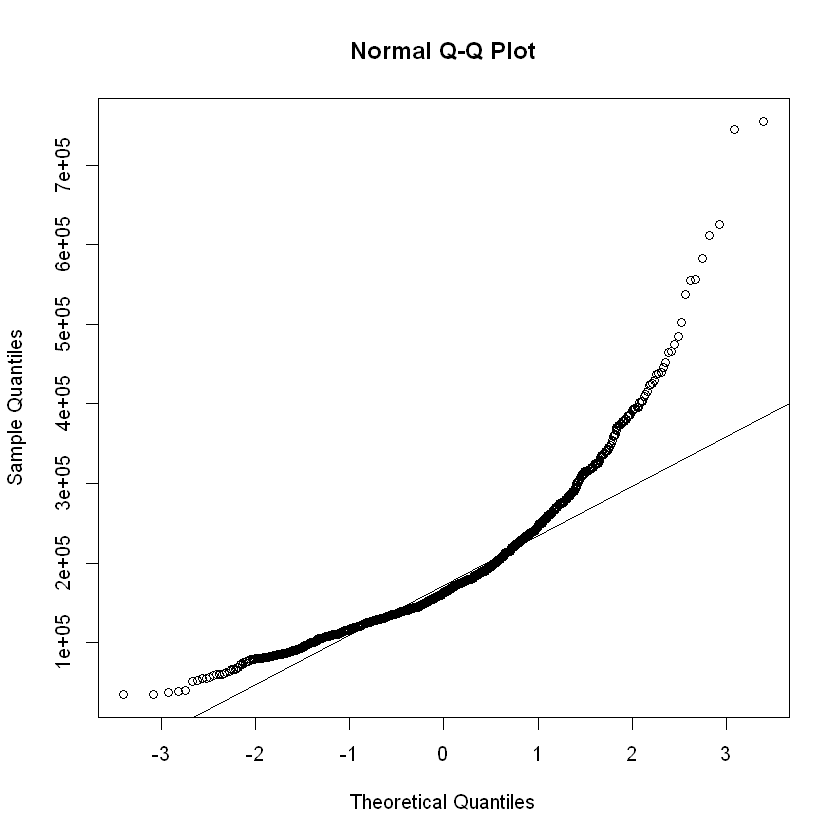

In [184]:
qqnorm(all$SalePrice)
qqline(all$SalePrice)

1.87의 skew는 right skew가 높다는 것을 나타낸다. Q-Q plot을 보면 sale prices가 잘 분배되어지지 않아 보인다. 따라서 SalePrice에 로그를 취했다.

In [185]:
all$SalePrice <- log(all$SalePrice) #default is the natural logarithm, "+1" is not necessary as there are no 0's
skew(all$SalePrice)

[1] 0.1213182

skew가 꽤 낮아졌고 Q-Q plot도 더 보기 좋아졌다.

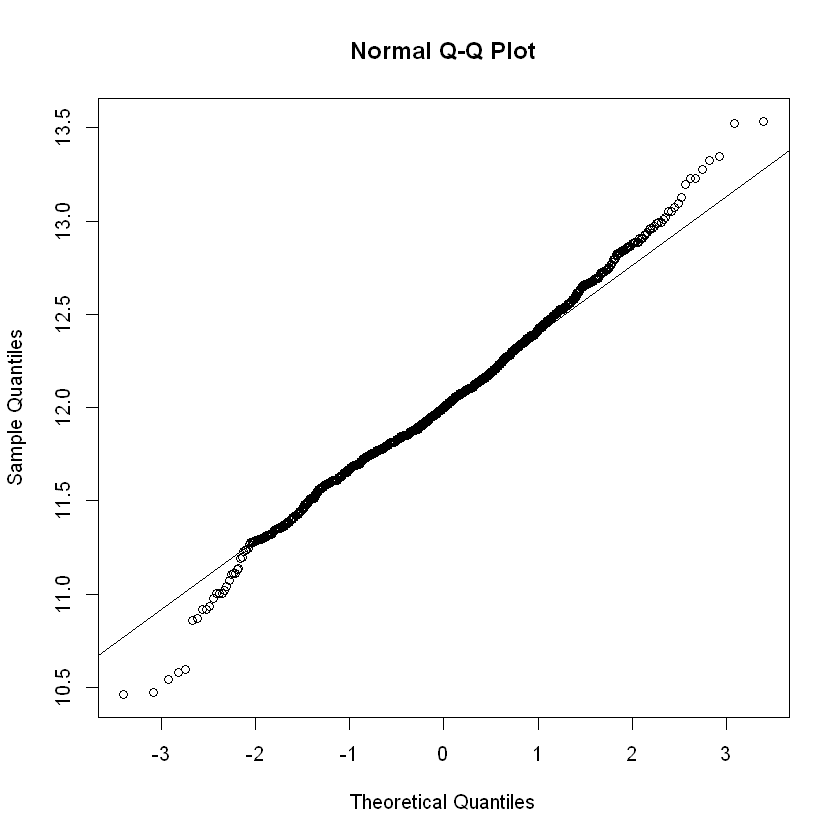

In [186]:
qqnorm(all$SalePrice)
qqline(all$SalePrice)

### 8.5 Composing train and test sets

In [187]:
train1 <- combined[!is.na(all$SalePrice),]
test1 <- combined[is.na(all$SalePrice),]

## 9 Modeling

### 9.1 Lasso regression model

Ridge와 Elastic Net 모델을 시도해봤지만 lasso가 이 중에 가장 좋은 결과를 낸 모델이었기 때문에 이 문서에서는 lasso만 사용하기로 했다.

elastic-net penalty는 알파에 의해 제어되며 lasso(알파=1)와 ridge(알파=0) 사이를 연결한다. 튜닝 매개 변수 람다는 penalty의 전체적인 강도를 조정한다. ridge penalty는 관련 있는 예측 변수들을 서로 축소시키는 반면 lasso는 그 중 하나를 선택하고 다른 것을 버리는 경향이 있다.

lasso 모델을 조정하기 위해 필요한 hyperparmeter의 최적값을 찾기 위해 caret cross validation을 사용하였다.

In [188]:
set.seed(27042018)
my_control <-trainControl(method="cv", number=5)
lassoGrid <- expand.grid(alpha = 1, lambda = seq(0.001,0.1,by = 0.0005))

lasso_mod <- train(x=train1, y=all$SalePrice[!is.na(all$SalePrice)], method='glmnet', trControl= my_control, tuneGrid=lassoGrid) 
lasso_mod$bestTune

,alpha,lambda
5,1,0.003


In [189]:
min(lasso_mod$results$RMSE)

[1] 0.1126497

caret의 'varlmp' function 문서에 의하면 glmboost와 glmnet의 경우 조정된 모델에 해당하는 계수의 절대값이 사용된다.

가장 중요 변수의 실제 랭킹은 저장되지 않지만 얼마나 많은 변수가 이 모델에서 사용되고 있는지 알 수 있게 해준다. (계수 0)

In [190]:
lassoVarImp <- varImp(lasso_mod,scale=F)
lassoImportance <- lassoVarImp$importance

varsSelected <- length(which(lassoImportance$Overall!=0))
varsNotSelected <- length(which(lassoImportance$Overall==0))

cat('Lasso uses', varsSelected, 'variables in its model, and did not select', varsNotSelected, 'variables.')

Lasso uses 100 variables in its model, and did not select 117 variables.

lasso는 예측한 대로 작동했다. 모델에서 이용가능한 변수의 약 45%를 이용하지 않음으로써 다중공선성을 잘 다뤘다.

In [191]:
LassoPred <- predict(lasso_mod, test1)
predictions_lasso <- exp(LassoPred) #need to reverse the log to the real values
head(predictions_lasso)

1461     1462     1463     1464     1465     1466 
114287.5 161140.0 179622.6 197367.5 205524.8 170466.0

### 9.2 XGBoost model

처음엔 XGBoost 패키지를 그냥 이용했다. 패키지는 각자 데이터 구조를 효율적으로 이용하기 때문이었다 (xgb.DMatrix). 이 패키지는 교차 검증 함수도 제공했다. 그러나 CV 함수는 최적의 횟수를 결정하기만 하고hyperparameter의 full grid search를 제공하지 않았다.

비록 caret이 xgb 패키지의 데이터 구조를 사용하지 않는 것 같지만 full grid search는 제공하고 있기에 caret으로 hyperparemeter tuning을 하기로 했다. 이해한 바로는 overfitting을 피하기 위한 주요 매개 변수는 max_depth와 min_child_wieght이다. 이 매개변수를 조정하는 grid를 아래에 설정했다.

In [192]:
xgb_grid = expand.grid(
nrounds = 1000,
eta = c(0.1, 0.05, 0.01),
max_depth = c(2, 3, 4, 5, 6),
gamma = 0,
colsample_bytree=1,
min_child_weight=c(1, 2, 3, 4 ,5),
subsample=1
)

best hyperparmeter 찾기

In [ ]:
#xgb_caret <- train(x=train1, y=all$SalePrice[!is.na(all$SalePrice)], method='xgbTree', trControl= my_control, tuneGrid=xgb_grid) 
#xgb_caret$bestTune

예상대로 시간이 꽤 걸렸다. Kaggle에서 타임을 제한하길 원하기 때문에 바로 결과로 진행하겠다. caret에 따르면 'bestTune' 매개 변수는:
- Max_depth=3
- eta=0.05
- Min_child_weight=4

xgboost 패키지를 계속 이어나가겠다. 추천하는 포맷으로 데이터를 준비한다.

In [193]:
label_train <- all$SalePrice[!is.na(all$SalePrice)]

# put our testing & training data into two seperates Dmatrixs objects
dtrain <- xgb.DMatrix(data = as.matrix(train1), label= label_train)
dtest <- xgb.DMatrix(data = as.matrix(test1))

caret 교차 검증에서 잘 조정된 값을 통제한다.

In [194]:
default_param<-list(
        objective = "reg:linear",
        booster = "gbtree",
        eta=0.05, #default = 0.3
        gamma=0,
        max_depth=3, #default=6
        min_child_weight=4, #default=1
        subsample=1,
        colsample_bytree=1
)

다음 순서는 베스트 횟수를 결정하기 위해 교차 검증을 하는 것이다.

In [195]:
xgbcv <- xgb.cv( params = default_param, data = dtrain, nrounds = 500, nfold = 5, showsd = T, stratified = T, print_every_n = 40, early_stopping_rounds = 10, maximize = F)

[1]	train-rmse:10.955588+0.004477	test-rmse:10.955537+0.019106 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[41]	train-rmse:1.428274+0.000561	test-rmse:1.428515+0.011791 
[81]	train-rmse:0.219833+0.000801	test-rmse:0.230612+0.009490 
[121]	train-rmse:0.102497+0.001285	test-rmse:0.128856+0.008654 
[161]	train-rmse:0.090461+0.001218	test-rmse:0.122128+0.007505 
[201]	train-rmse:0.084295+0.001135	test-rmse:0.119680+0.007363 
[241]	train-rmse:0.079623+0.001177	test-rmse:0.118523+0.007181 
[281]	train-rmse:0.076073+0.001198	test-rmse:0.117612+0.006738 
[321]	train-rmse:0.073001+0.001162	test-rmse:0.117045+0.006529 
[361]	train-rmse:0.070182+0.000952	test-rmse:0.116571+0.006461 
[401]	train-rmse:0.067571+0.000829	test-rmse:0.116436+0.006349 
Stopping. Best iteration:
[398]	train-rmse:0.067781+0.000827	test-rmse:0.116397+0.006379



교차 검증된 RMSE는 상당히 증진되었기에 hyperparameter tuning은 가치가 있었다. (caret tuning 없이 0.1225에서 0.1162로!)

In [196]:
#train the model using the best iteration found by cross validation
xgb_mod <- xgb.train(data = dtrain, params=default_param, nrounds = 454)

In [197]:
XGBpred <- predict(xgb_mod, dtest)
predictions_XGB <- exp(XGBpred) #need to reverse the log to the real values
head(predictions_XGB)

[1] 118017.9 162105.9 188016.4 188469.1 188521.4 166058.6

In [200]:
install.packages("Ckmeans.1d.dp", repos="http://cran.us.r-project.org")

package 'Ckmeans.1d.dp' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\semai\AppData\Local\Temp\Rtmpearq29\downloaded_packages


Warning message:
"package 'Ckmeans.1d.dp' was built under R version 3.5.2"

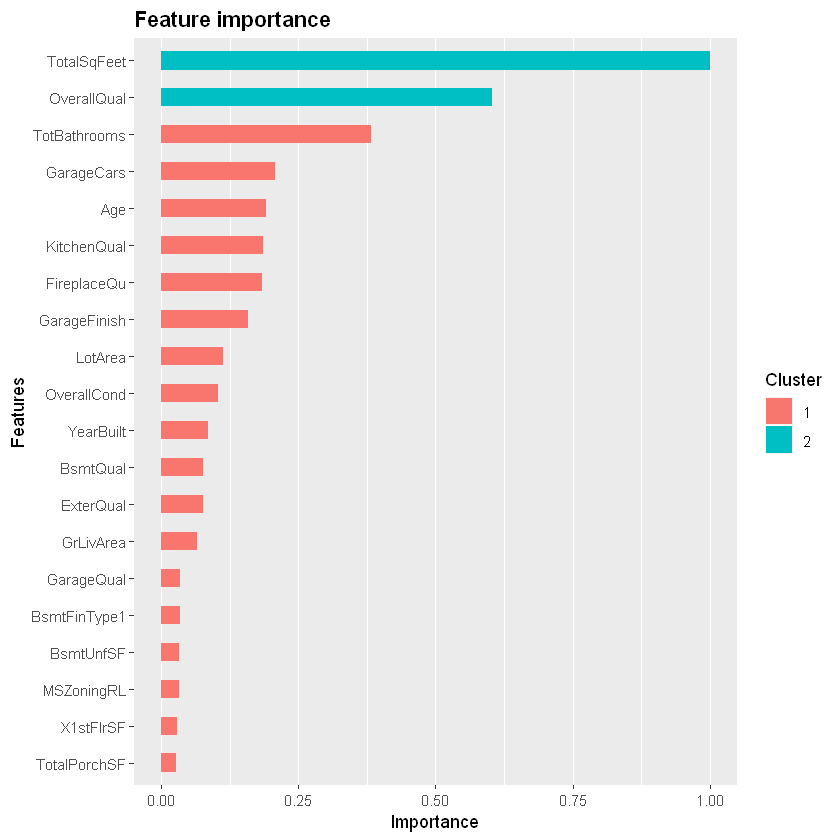

In [201]:
#view variable importance plot
library(Ckmeans.1d.dp) #required for ggplot clustering
mat <- xgb.importance (feature_names = colnames(train1),model = xgb_mod)
xgb.ggplot.importance(importance_matrix = mat[1:20], rel_to_first = TRUE)

### 9.3 Averaging predictions

lasso와 XGBoost 알고리즘은 매우 다르므로 평균 예측은 스코어를 증진시킨다. 교차 검증된 RMSE 스코어 (0.1121 vs 0.1162)에 따르면 lasso 모델이 좋다. lasso 모델에 두 배의 가중치를 뒀다.

In [202]:
sub_avg <- data.frame(Id = test_labels, SalePrice = (predictions_XGB+2*predictions_lasso)/3)
head(sub_avg)

,Id,SalePrice
1461,1461,115530.9
1462,1462,161462.0
1463,1463,182420.5
1464,1464,194401.4
1465,1465,199857.0
1466,1466,168996.9


In [203]:
write.csv(sub_avg, file = 'average.csv', row.names = F)